In [11]:
###IMPORTS
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

In [12]:
###UTILS_TF
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time

class optimizer_SGD_VI:
    def __init__(self,ELBO,p1,llkl,states,vars2optimize=None,learning_rate=0.01,learning_beta=0.9,train_epochs_limit_max=1000,train_epochs_limit_min=10):
        '''Class used to run an SGD optimization of the Elbo. It also estimates maximum likelihood and maximum-a-posteriori (MAP).'''
        self.learning_rate=learning_rate
        self.learning_beta=learning_beta #The momentum parameters for the Adam optimizer
        self.train_epochs_limit_min=np.min([train_epochs_limit_min,train_epochs_limit_max])
        self.train_epochs_limit_max=np.max([train_epochs_limit_min,train_epochs_limit_max])
        self.reset_training()
        self.ELBO=tf.reduce_mean(ELBO)
        self.states=states
        self.p1=p1
        self.llkl=llkl
        if not vars2optimize is None:
            self.optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=self.learning_beta).minimize(self.ELBO,var_list=vars2optimize)
        else:
            self.optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=self.learning_beta).minimize(self.ELBO)
    def step(self, sess, batch_train=None,audit=None):
        '''Makes an SGD steps, verify if any particle is the new MAP or a new maximum-likelihood'''
        self.ii+=1
        _elbo,_p1,_llkl,_,_states=sess.run([self.ELBO,self.p1,self.llkl,self.optimizer,self.states],feed_dict=batch_train)            
        if np.isnan(_elbo):
            raise Exception(f'loss function gave NaN result')
        _is_min=True
        if self.ii==0:
            self.ii_min=self.ii
            self.MAP=-np.Inf
            self.max_lkl=-np.Inf
        elif _elbo<self.values[self.ii_min]:
            self.ii_min=self.ii
        else:
            _is_min=False
        if _is_min and not audit is None:
            audit.log_tensorflow(sess)
        self.values[self.ii]=_elbo
        self.is_min_value[self.ii]=_is_min
        #saves the minimum of the point loss
        _llkl_globalTime=np.sum(_llkl,axis=1)
        _llkl_max=np.max(_llkl_globalTime)
        if _llkl_max>self.max_lkl:#if true, it is the new max-likelihood
            self.particle_max_llkl=np.argmax(_llkl_globalTime)
            self.max_lkl=_llkl_globalTime[self.particle_max_llkl]
            self.states_maxllkl=_states
        _p1_max=np.max(_p1)
        if _p1_max>self.MAP:#if true, it is the new MAP
            self.MAP=_p1_max
            self.particle_MAP=np.argmax(_p1)
            self.MAP_llkl=np.sum(_llkl[self.particle_MAP])
            self.states_MAP=_states
        return _is_min,_states,_llkl
    def min_is_recent(self):
        '''Gives true if the max of the ELBO is more then train_epochs_limit_min in the past training time'''
        return np.abs(self.ii-self.ii_min)<self.train_epochs_limit_min
    def max_train_reached(self):
        '''Gives true if the maximum training time is reached'''
        return self.ii>=self.train_epochs_limit_max-1
    def reset_training(self):
        '''Reset the training time, initializing internal variables'''
        self.values=np.zeros(self.train_epochs_limit_max)
        self.is_min_value=np.zeros(self.train_epochs_limit_max)
        self.ii=-1
        self.ii_min=-1
    def get_ELBO(self):
        '''Returns the historical ELBO values, obtained during training'''
        if self.ii>=0:
            return self.values[:self.ii+1]
        else:
            return None
    def get_MAP(self):
        '''Returns the MAP parameters and value'''
        states_MAP=self.states_MAP
        particle_MAP=self.particle_MAP
        _states={}
        for st in states_MAP:
            _states[st]=(states_MAP[st])[particle_MAP:particle_MAP+1]
        return _states,self.MAP_llkl
    def get_maxllkl(self):
        '''Returns the max-likelihood parameters and value'''
        states_maxllkl=self.states_maxllkl
        particle_max_llkl=self.particle_max_llkl
        _states={}
        for st in states_maxllkl:
            _states[st]=(states_maxllkl[st])[particle_max_llkl:particle_max_llkl+1]
        return _states,self.max_lkl

class audit:
    '''
    Class used to save the tensorflow session and to create the folders where to save other files.
    '''
    def __init__(self,name,save_path,save_jpynb=None):
        import shutil
        import os
        now_string=datetime.datetime.now().strftime('%Y%m%d %H%M%S')
        folder2save = f'{save_path}\\{name} {now_string}'
        if not os.path.exists(folder2save):
            os.makedirs(folder2save)
        self.folder2save=folder2save
        self.saver=tf.train.Saver()
        self.file2save=self.folder2save + '\\tf'
        if not save_jpynb is None:
            source_path=os.getcwd()+save_jpynb
            if os.path.exists(source_path):
                shutil.copy2(source_path,folder2save + '\\' + save_jpynb)
        self.tf_saver=tf.train.Saver()        
    def log_tensorflow(self,sess):
        self.tf_saver.save(sess,self.file2save)
        print(f'tensorflow saved at:\n{self.file2save}')
    def restore_tensorflow(self,sess):
        self.tf_saver.restore(sess, self.file2save)

def tf_VectorsCrossProduct(x):
    '''Creates cross-product of tensors'''
    len_shape_x=len(x.shape)
    rx=tf.reshape(x,[*x.shape,1])
    cross_x=tf.matmul(rx,tf.transpose(rx,np.concatenate([np.arange(len_shape_x-1),[len_shape_x,len_shape_x-1]])))
    return cross_x

In [13]:
#abstract classes, the interfaces
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from utils_ts import inv_softplus,indexes_librarian,view_stats

class VIsampler_abstract:
    '''This class represents the abstract interface that a sampler must implement to fit the package guidelines.
    states represents a dictionary with the parameters tensors.
    entropy represents an MC tensors with an estimates of the entropy of the sampler (or the exact value, if available)'''
    def __init__(self,name,MC,states,entropy):
        self.name=name
        self.MC=MC
        self.states=states
        self.entropy=entropy
    def get_samples(self,sess,size=None):
        '''samples the states, evaluating the tensors and returning a dictionary with the numpy ndarray.'''
        if size is None:
            size=self.MC
        states=self.states
        ret={}
        for state in states:
            ret[state]=np.zeros([size,*states[state].get_shape().as_list()[1:]],dtype=np.float32)            
        ii=0
        while size>0:
            di=np.min([self.MC,size])
            sam=sess.run(self.states)
            for state in states:
                ret[state][ii:ii+di]=sam[state][:di]
            size-=di
            ii+=di
        return ret    
    def diagnostic(self,sess):
        '''This functions will be called to evaluate the behaviour of the sampler while training.'''
        states_np=sess.run(self.states)
        print(f'\n')
        for state in states_np:
            print(f'state {state}:n')
            view_stats(states_np[state])
class p0_abstract:
    '''
    The abstract class used to represent a prior distribution.
    name is a string with the proper name of the prior.
    p0_fun is a function that takes the tensors (representing MC particles of parameters) as inputs and gives a tensor with the log-value of their prior.
    '''
    def __init__(self,name,p0_fun):
        self.name=name
        self.p0_fun=p0_fun
        
class Dynamics_abstract:
    '''The class that represent the requested dynamic of the parameters.
    llkl_fun is a function that takes the tensors (representing MC particles of parameters) as inputs and gives a tensor with the log-value of their likelihood.'''
    def __init__(self,llkl_fun):
        self.name=name
        self.llkl_fun=llkl_fun
    def evolve_states(self,sess,**kwargs):
        '''This function takes MC parameters particles, and evolve the time-varying ones accordingly.        
        Gives back the results as numpy ndarray.
        sess is an active tensorflo session, used to evaluate/evolve the parameters.
         **kwargs covers the parameters.'''
        ret=sess.run(kwargs)
        return ret
    
class BayesianModel_abstract:
    '''
    The abstract class used to represent a model for data (likelihood and prior).
    llkl_fun is a function that takes y and tensors (representing MC particles of parameters) as inputs, and gives the value of the log-likelihood of y.
    p0_fun does the same but gives back the prior log-value for each MC particle.
    dynamics is an object inheriting from Dynamics_abstract.
    '''
    def __init__(self,name,llkl_fun,p0_fun,dynamics):        
        self.name=name
        self.llkl_fun=llkl_fun
        self.p0_fun=p0_fun
        self.dynamics=dynamics
    def forecast_logProb(self,y,sess,**kwargs):
        '''Evaluates the log-probability of y, given a set of parameters.
        y is the data to forecast.
        sess is an active tensorflow session.
        **kwargs represents the parameters.'''
        _parameters=self.dynamics.evolve_states(sess,**kwargs)
        _logProb=self._get_LogProb(y,sess,**_parameters)
        return _logProb
    def _get_LogProb(self,y,sess,**kwargs):
        '''Evaluates the log-likelihood of y, using the parameters in **kwargs and the active session sess.
        Private method not intended for outside calls.'''
        llkl=sess.run(self.llkl_fun(y,**kwargs))
        if len(llkl.shape)==2:            
            MC=llkl.shape[0]
            ret=tf.reduce_logsumexp(llkl,axis=0)-np.log(MC)
        else:
            ret=llkl
        return sess.run(ret)
class EstimatorVariationalBayes:
    '''This class collects a model a sampler and data y to run the SGD optimization.
    model inherits from BayesianModel_abstract.
    sampler inherits from VIsampler_abstract.
    '''
    def __init__(self,y,model,sampler):
        self.p0=model.p0_fun(**sampler.states)
        self.dynamics=model.dynamics.llkl_fun(**sampler.states)
        self.llkl_y=model.llkl_fun(y,**sampler.states)
        self.llkl=tf.reduce_sum(self.llkl_y,axis=1)+self.dynamics
        p1=self.p0+self.llkl
        self.KL=-sampler.entropy-p1
        self.p1=p1
        self.model=model
        self.sampler=sampler
        self.llkl_test_values=[]
        self.llkl_train_values=[]
    def set_optimizer_KL(self,vars2optimize=None,learning_rate=0.01,learning_beta=0.9,train_epochs_limit_max=1000,train_epochs_limit_min=10):
        '''Functions that creates the optimizer with the given tuning parameters.'''
        self.optim_KL=optimizer_SGD_VI(self.KL,self.p1,self.llkl_y,self.sampler.states,vars2optimize,learning_rate,learning_beta,train_epochs_limit_max,train_epochs_limit_min)
    def run_inference(self,sess,diagnostic=False,KL=True,audit=None,y_forecast=None):
        '''Run the SGD inference.
        sess is an active tf session.
        diagnostic=True will run the sampler diagnostic function whenever a new maximum for ELBO is reached (minimum for the KL).
        audit is an instance f the audit class, used to log the tensorflow computational graph at every minimum, if None, the last state is kept.
        if y_forecast is provided, the log probability of y forecasted at every step.
        '''
        optim=self.optim_KL
        while optim.min_is_recent() and not optim.max_train_reached():            
            print(f'train round: {optim.ii}')
            t0=time.time()
            _step,_states,_llkl=optim.step(sess,audit=audit)            
            if not y_forecast is None:#
                self.llkl_train_values.append(self.model.forecast_logProb(y_forecast,sess,**_states))
                _=sess.run(tf.reduce_logsumexp(_llkl,axis=0)-np.log(_llkl.shape[0])).mean()
                self.llkl_test_values.append(_)                
            t1=time.time()
            print(f'step time: {t1-t0}')
            if _step and diagnostic:#maximum of elbo is reached and diagnostic=True, implies sampler diagnostic should run.
                self.sampler.diagnostic(sess)
        if not audit is None:#then it restores the tf state at the last maximum of the ELBO.            
            audit.restore_tensorflow(sess)
        return self.optim_KL.get_ELBO(),self.llkl_train_values,self.llkl_test_values
    def sample_log_lkl(self,sess):
        '''samples the log_lkl of the model on the training set.'''
        _llkl=sess.run(tf.reduce_logsumexp(self.llkl_y,axis=0))-np.log(self.sampler.MC)
        return np.sum(_llkl)

class VIwrapper_abstract:
    '''Class used to connect a reparametrization a the admissible posteriors, a model and tuning parameters for SGD.
    This is used to create off-the-shelf forecasters of data.
    name is a stirng with the specific name of the instance.
    y are date, with shape (T,N)
    MC is the number of MC particles to use at every step
    sampler is a reparametrization of the set of admissible posteriors, allowing to samples from it and to evaluate the entropy.
    '''
    def __init__(self,name,y,MC,sampler,model,learning_rate=0.1,train_epochs_limit_min=10,train_epochs_limit_max=1000):        
        estimatorVI=EstimatorVariationalBayes(name+'_estimatorVI',y,model,sampler)        
        estimatorVI.set_optimizer_KL(learning_rate=learning_rate,learning_beta=1.0-learning_rate,train_epochs_limit_max=train_epochs_limit_max,train_epochs_limit_min=train_epochs_limit_min)
        #implements the interface
        self.name=name
        self.MC=MC
        self.y=y
        self.model=model
        self.sampler=sampler
        self.estimatorVI=estimatorVI
    def run_inference(self,sess,audit=None,diagnostic=False):
        '''This functions runs the inference., by passing the command to the internal object that is devoted to.'''
        ELBO,train_llkl,test_llkl=self.estimatorVI.run_inference(sess,diagnostic=diagnostic,audit=audit)
        if not audit is None:
            audit.restore_tensorflow(sess)
        return ELBO,train_llkl,test_llkl
    def forecast_VI(self,sess,size=None, **kwargs):
        '''Samples parameters using the sampler and evolving the time-varying ones according to the parameters dynamics.'''
        if size is None:
            size=self.MC
        _states=self.sampler.get_samples(sess=sess,size=size)
        ret=self.sampler.forecast(sess=sess,size=size,**_states, **kwargs)
        return ret
    def forecast_MAP(self,sess, **kwargs):
        '''Returns the MAP parameters sampled during inference'''
        _states,_MAP=self.estimatorVI.optim_KL.get_MAP()
        ret=self.sampler.forecast(sess=sess,**_states, **kwargs)
        return ret,_MAP
    def forecast_maxLkl(self,sess, **kwargs):
        '''Returns the parameters with the maximum likelihood, sampled during the inference'''
        _states,_maxLkl=self.estimatorVI.optim_KL.get_maxllkl()
        ret=self.sampler.forecast(sess=sess,**_states, **kwargs)
        return ret,_maxLkl
    def get_logPy(self, y, sess, size_MC=None,VI=True,MAP=True,maxLkl=True, **kwargs):
        '''Given data y and an active tf session, it returns the logProbability obtained during forecasting it with:
        MAP parameters, max-likelihood parameters, and sice_MC particles sampled from the reparametrized sampler.
        **kwargs is used in case additional parameters are requested (such as regressors x)'''
        ret_test={}
        ret_train={}
        if VI:
            _samples_VI=self.forecast_VI(sess=sess,size=size_MC, **kwargs)
            ret_VI=self.model.get_LogProb(y=y,sess=sess,**_samples_VI)
            ret_test['VI']=ret_VI
            ret_train['VI']=self.estimatorVI.sample_log_lkl(sess)
        if MAP:
            _samples_MAP,_MAP=self.forecast_MAP(sess=sess, **kwargs)
            ret_MAP=self.model.get_LogProb(y=y,sess=sess,**_samples_MAP)
            ret_test['MAP']=ret_MAP
            ret_train['MAP']=_MAP            
        if maxLkl:
            _samples_maxLkl,_maxLkl=self.forecast_maxLkl(sess=sess, **kwargs)
            ret_maxLkl=self.model.get_LogProb(y=y,sess=sess,**_samples_maxLkl)        
            ret_test['maxLkl']=ret_maxLkl
            ret_train['maxLkl']=_maxLkl
        return ret_test,ret_train
    

classes inheriting from the above classes follows from here.
This subclasses will represents specifics models, specific priors and specifics reparametrizations of sets of distributions.

In [14]:
#models
class BayesianModel_MeanCholVcv(BayesianModel_abstract):
    '''Class that represents a multivariate state-space model, with states that are the mean of the observed vector and the cholesky-decomposition of its covariance matrix.    
    '''
    def __init__(self,name,p0_fun,dynamics):
        def llkl_fun(y,Ey,cholVcv,**kwargs):
            pdf_y=tfp.distributions.MultivariateNormalTriL(Ey,scale_tril=cholVcv,name=name+'_pdf')
            y_llkl=pdf_y.log_prob(y)
            return y_llkl
        BayesianModel_abstract.__init__(self,name,llkl_fun,p0_fun,dynamics)
class BayesianModel_MeanVcv(BayesianModel_abstract):
    '''Class that represents a multivariate state-space model, with states that are the mean of the observed vector and its covariance matrix.
    '''
    def __init__(self,name,p0_fun,dynamics):
        def llkl_fun(y,Ey,Vcv,**kwargs):
            pdf_y=tfp.distributions.MultivariateNormalFullCovariance(Ey,Vcv,name=name+'_pdf')
            y_llkl=pdf_y.log_prob(y)
            return y_llkl
        BayesianModel_abstract.__init__(self,name,llkl_fun,p0_fun,dynamics)

In [15]:
#priors
from utils_ts import inv_softplus,indexes_librarian

class p0_unionOfp0s(p0_abstract):
    '''This class just glues different priors together.
    The log-prior resulting will have as value the sum of the values of the single log-priors.
    '''
    def __init__(self,name,p0s):
        def p0_fun(**kwargs):
            p0value=0.0
            for p0 in p0s:#for every prior, adds its log-value to the final value
                p0value=p0value+p0.p0_fun(**kwargs)
            return p0value
        p0_abstract.__init__(self,name,p0_fun)

def prior_normalWishart(name,init_normal_mean,init_normal_vcv,init_W_mean,init_W_df):
    '''A prior function on a pair of (vector,positive matrix).
    The prior uses two independent distributions, a multivariate gaussian over the vector and a Wishart distributions over the covariance matrix.
    vector ~ Normal(init_normal_mean,init_normal_vcv)
    matrix ~ Wishart(init_W_df,init_W_mean/init_W_df)
    '''
    N=init_normal_mean.shape[0]
    assert N==init_W_mean.shape[0]
    assert N==init_W_mean.shape[1]
    assert N<=init_W_df
    prior_normal=tfp.distributions.MultivariateNormalFullCovariance(np.float32(init_normal_mean),np.float32(init_normal_vcv),name=name+'_normal')
    prior_W=tfp.distributions.Wishart(np.float32(init_W_df),np.float32(init_W_mean/init_W_df),input_output_cholesky=True,name=name+'_W')
    def prior_var(sam_normal,sam_W):
        prior_t0=tf.reduce_mean(prior_normal.log_prob(sam_normal))+tf.reduce_mean(prior_W.log_prob(sam_W))
        prior_t0=prior_normal.log_prob(sam_normal)+prior_W.log_prob(sam_W)
        return prior_t0
    return prior_var

def prior_Beta(name,a,b):
    '''Beta distribution prior with parameters a,b.
    '''
    pdf_p=tfp.distributions.Beta(a,b,name=name)
    def prior(sam):
        return tf.reduce_mean(pdf_p.log_prob(sam),axis=1)
    return prior

class p0_DCC(p0_abstract):
    '''
    A prior over a set of DCC parameters.
    Concerning the GARCH components of the kind sigma_t^2=mu+alpha*(sigma_{t-1}^2)+beta*epsilon_t^2.
    A Gamma distribution is used for mu. A Beta distribution is used for alpha, and another Beta distribution for beta/(1-alpha).
    Concerning the correlations coefficients a,b: 
    '''
    def __init__(self,name,N,fitGammaAlpha_mu,fitGammaBeta_mu,fitBetaA_alpha, fitBetaB_alpha,fitBetaA_beta, fitBetaB_beta,fitBetaA_a,fitBetaB_a,fitBetaA_b,fitBetaB_b,**kwargs):
        pdf_alphas=tfp.distributions.Beta(np.float32(fitBetaA_alpha),np.float32(fitBetaB_alpha))
        pdf_betas=tfp.distributions.Beta(np.float32(fitBetaA_beta),np.float32(fitBetaB_beta))
        pdf_mus=tfp.distributions.Gamma(np.float32(fitGammaAlpha_mu),np.float32(fitGammaBeta_mu))
        pdf_a=tfp.distributions.Beta(np.float32(fitBetaA_a),np.float32(fitBetaB_a))
        pdf_b=tfp.distributions.Beta(np.float32(fitBetaA_b),np.float32(fitBetaB_b))
        def p0_fun(GARCH_alphas,
            GARCH_betas,
            GARCH_mus,
            DCC_a,
            DCC_b,
            **kwargs):
            p0value_alphas = pdf_alphas.log_prob(GARCH_alphas)
            p0value_betas = pdf_betas.log_prob(GARCH_betas/(1.0-GARCH_alphas))
            p0value_mus = pdf_mus.log_prob(GARCH_mus)
            p0value_a = pdf_a.log_prob(DCC_a)
            p0value_b = pdf_b.log_prob(DCC_b)
            #the values of the densities
            p0value=tf.reduce_mean(p0value_alphas+p0value_betas+p0value_mus,axis=(1))*N+tf.reduce_mean(p0value_a+p0value_b,axis=(1,2))
            return p0value
        p0_abstract.__init__(self,name,p0_fun)


class p0_independentGaussianJumps(p0_abstract):
    '''A prior over independent jumps with multivariate gaussian components.
    The jumps rate of occurence will have a Beta prior distribution with parameters init_success_Beta[0],init_success_Beta[1]
    The jumps mean will have a multivariate gaussian distribution N(init_jumpsMean_mean,init_jumpsMean_vcv).
    The covariance matrix of the jumps distribution will have a Wishart prior W(init_jumpsVcv_df,init_jumpsVcv_mean/init_jumpsVcv_df).
    The three distribution are independent.
    '''
    def __init__(self,name,
                 init_success_Beta,
                 init_jumpsMean_mean,
                 init_jumpsMean_vcv,
                 init_jumpsVcv_mean,
                 init_jumpsVcv_df,
                 **kwargs):
        p0_jump_rate=prior_Beta(name+'_jumps_rate',init_success_Beta[0],init_success_Beta[1])
        p0_jumps_moments=prior_normalWishart(name+'_jumps_moments',init_jumpsMean_mean,init_jumpsMean_vcv,init_jumpsVcv_mean,init_jumpsVcv_df)
        def p0_fun_MC(Jumps_rate,Jumps_mean,Jumps_vcv,**kwargs):            
            p0value_moments=p0_jumps_moments(Jumps_mean,Jumps_vcv)
            p0value_rates=p0_jump_rate(Jumps_rate)            
            p0value=p0value_moments+p0value_rates
            return p0value
        p0_abstract.__init__(self,name,p0_fun_MC,p0_fun_MC)


In [16]:
#dynamics
class Dynamics_cholVcv_OUbrownian(Dynamics_abstract):
    '''Class used to represents an Ornstein-Uhlenbeck dynamics for the components of a triangular matrix.
     
    '''
    def __init__(self,name):  
        def llkl_fun(cholVcv,line_cholVcv,W,OU_theta=None,OU_mu_line=None,**kwargs):
            [MC,T,N,_]=cholVcv.get_shape().as_list()
            if not OU_mu_line is None:
                dvcv_mean=tf.reshape(OU_theta,[MC,1])*OU_mu_line
            else:
                dvcv_mean=np.zeros([MC,num_tril],dtype=np.float32)
            pdf_dvcv = tfp.distributions.MultivariateNormalTriL(dvcv_mean, scale_tril=W, name=name+'_pdf_dVcv')
            if OU_mu_line is None:
                dvcv=tf.transpose(line_cholVcv[:,1:,:]-line_cholVcv[:,:-1,:],[1,0,2])                
            else:
                dvcv=tf.transpose(line_cholVcv[:,1:,:]+(tf.reshape(OU_theta,[MC,1,1])-1.0)*line_cholVcv[:,:-1,:],[1,0,2])
            p0value_dvcv=pdf_dvcv.log_prob(dvcv, name=name+'_p0Value_dvcv')
            p0value=tf.reduce_sum(p0value_dvcv,axis=0)
            return p0value
        Dynamics_abstract.__init__(self,name,llkl_fun)
    def evolve_states(self,sess,cholVcv,W, OU_theta, OU_mu, OU_mu_line, line_cholVcv,**kwargs):        
        dt=1#by now only one-step-ahead forecast is implemented
        if len(cholVcv.shape)==4:#then I have multiple MC particles
            [MC,T,N,_]=cholVcv.shape
            num_tril=int(N*(N+1)/2)
            mcholVcv=cholVcv[:,-1]
            mOU_theta=OU_theta.reshape([MC,1])
            mOU_mu=OU_mu
            mOU_mu_line=OU_mu_line
            mW=W
            mline_cholVcv=line_cholVcv[:,-1]#.reshape([MC,1,num_tril])
            dcVcv=(mW@np.random.randn(MC,num_tril,1)).reshape([MC,num_tril])
            newline_cholVcv=(mline_cholVcv*(1.0-mOU_theta)+dcVcv+mOU_theta*mOU_mu_line).reshape([MC,dt,num_tril])            
        else:#just a single particle
            MC=1
            [T,N,_]=cholVcv.shape
            num_tril=int(N*(N+1)/2)
            mcholVcv=cholVcv[-1]
            mOU_theta=OU_theta
            mOU_mu=OU_mu
            mOU_mu_line=OU_mu_line
            mW=W
            mline_cholVcv=line_cholVcv[-1]
            dcVcv=mW@np.random.randn(num_tril,1).reshape([num_tril])
            newline_cholVcv=mline_cholVcv*(1.0-mOU_theta)+dcVcv+mOU_theta*mOU_mu_line
            newline_cholVcv=newline_cholVcv.reshape([1,dt,num_tril])            
        new_vcv,_,_=self.shape_vcv(self.name+'forecast',newline_cholVcv,MC=MC,T=dt,N=N)
        if sess is None:
            init = tf.global_variables_initializer()
            with tf.Session() as sess:
                sess.run(init)
                fc_vcv=sess.run(new_vcv)
        else:
            fc_vcv=np.float32(sess.run(new_vcv))
        ret={'cholVcv':fc_vcv}    
        return ret
    def shape_vcv(self,name,sam_not_shaped,MC,T,N,LD_reparametrize=False):        
        _tol=1e-12
        min_diag=np.exp(np.log(_tol)/N)
        ind_precomputed=indexes_librarian(N)
        if LD_reparametrize:
            sam_diag_line = tf.nn.softplus(tf.gather(sam_not_shaped,ind_precomputed.spiral_diag,axis=2))
            sam_diag = tf.linalg.diag(sam_diag_line+min_diag)
            sam_udiag_line = tf.gather(sam_not_shaped,ind_precomputed.spiral_udiag,axis=2)
            tf_ones_diagVcv=np.ones([MC,T,N],dtype=np.float32)
            sam_udiag=tf.linalg.set_diag(tfp.distributions.fill_triangular(sam_not_shaped),tf_ones_diagVcv)
            sam=tf.matmul(sam_udiag,sam_diag, name=name+"_sam")
        else:
            sam_diag_line = tf.nn.softplus(tf.gather(sam_not_shaped,ind_precomputed.spiral_diag,axis=2))
            sam_udiag_line = tf.gather(sam_not_shaped,ind_precomputed.spiral_udiag,axis=2)
            sam_diag = tf.linalg.diag(sam_diag_line+min_diag)
            sam_udiag=tfp.distributions.fill_triangular(sam_not_shaped)
            #BOLZ
            bijsoftplus=tfp.bijectors.TransformDiagonal(tfp.bijectors.Softplus())
            sam=bijsoftplus.forward(tfp.distributions.fill_triangular(sam_not_shaped),name=name+'sam_shaped')
            #sam=tf.linalg.set_diag(tfp.distributions.fill_triangular(sam_not_shaped),sam_diag_line,name=name+'sam')
        return sam,sam_diag_line,sam_udiag_line
class Dynamics_staticMean(Dynamics_abstract):
    def __init__(self,name):
        def llkl_fun(**kwargs):
            return np.float32(0.0)
        Dynamics_abstract.__init__(self,name,llkl_fun)
    def evolve_states(self,sess,Ey,**kwargs):
        return {'Ey':Ey[:,-1:]}
class Dynamics_DCC(Dynamics_abstract):    
    def __init__(self,name):
        def llkl_fun(**kwargs):
            return np.float32(0.0)
        Dynamics_abstract.__init__(self,name,llkl_fun)
    def evolve_states(self,sess,Vcv_forecast,**kwargs):
        return {'Vcv':Vcv_forecast}
class Dynamics_IndependentJumps(Dynamics_abstract):
    def __init__(self,name):
        def llkl_fun(Jumps_rate,Jumps_mean,Jumps_vcv,Jumps_softId_t,Jumps_values_t,**kwargs):    
            MC,T,N=Jumps_values_t.get_shape().as_list()
            mean_jumps_ids_t=tf.reduce_mean(Jumps_softId_t,axis=1)
            p0value_softId_t=tf.reduce_mean(mean_jumps_ids_t*Jumps_rate+(1-mean_jumps_ids_t)*(1-Jumps_rate),axis=1)
            pdf_values=tfp.distributions.MultivariateNormalTriL(tf.reshape(Jumps_mean,[MC,1,N]),tf.reshape(Jumps_vcv,[MC,1,N,N]))
            p0value_values_t=tf.reduce_mean(pdf_values.log_prob(Jumps_values_t),axis=1)
            p0value=p0value_softId_t+p0value_values_t
            return p0value
        Dynamics_abstract.__init__(self,name,llkl_fun)
    def evolve_states(self,sess,Jumps_rate,Jumps_mean,Jumps_vcv,**kwargs):
        if len(Jumps_rate.shape)==1:
            Jumps_rate=Jumps_rate.reshape([1,1])
            Jumps_mean=Jumps_mean.reshape([1,-1])
            [MC,N]=Jumps_mean.shape
            Jumps_vcv=Jumps_vcv.reshape([1,N,N])
        else:
            [MC,N]=Jumps_mean.shape
        ret={}
        rate_np,mean_np,vcv_np=Jumps_rate,Jumps_mean,Jumps_vcv@Jumps_vcv.transpose([0,2,1])
        Jumps_id=np.float32(np.random.binomial(1,rate_np))
        Jumps_values=np.zeros([MC,N],dtype=np.float32)
        for mc in range(MC):
            Jumps_values[mc]=np.random.multivariate_normal(mean_np[mc],vcv_np[mc])
        Ey=Jumps_id*Jumps_values
        Ey=Ey.reshape([MC,1,-1])
        ret={'Ey':Ey}
        return ret
    
class Dynamics_merge(Dynamics_abstract):
    def __init__(self,name,dynamics2merge):
        self.merged=dynamics2merge
        def llkl_fun(**kwargs):
            ret=None
            for dyn in self.merged:
                if ret is None:
                    ret=dyn.llkl_fun(**kwargs)
                else:
                    ret=ret+dyn.llkl_fun(**kwargs)
            return ret
        Dynamics_abstract.__init__(self,name,llkl_fun)
    def evolve_states(self,sess,**kwargs):
        ret=None
        for dyn in self.merged:
            if ret is None:
                ret=dyn.evolve_states(sess,**kwargs)
            else:
                ret={**ret,**(dyn.evolve_states(sess,**kwargs))}
        return ret

In [17]:
#samplers
class VIsampler_NullVector(VIsampler_abstract):
    def __init__(self,name,MC,T,N,**kwargs):
        Ey=tf.constant(np.zeros([MC,T,N],dtype=np.float32))
        self.T,self.N=T,N
        states={'Ey':Ey}
        #entropy
        entropy=0.0
        #implements the interface
        VIsampler_abstract.__init__(self,name,MC,states,entropy)
    def forecast(self,sess,Ey=None,**kwargs):
        return {'Ey':np.zeros([1,1,self.N],dtype=np.float32)}
class VIsampler_Beta(VIsampler_abstract):
    def __init__(self,name,MC,init_a,init_b,**kwargs):
        lambda_a=tf.nn.softplus(tf.get_variable(name+"_lambda_a",dtype=tf.float32,initializer=inv_softplus(init_a)))
        lambda_b=tf.nn.softplus(tf.get_variable(name+"_lambda_b",dtype=tf.float32,initializer=inv_softplus(init_b)))
        pdf_beta=tfp.distributions.Beta(lambda_a,lambda_b,name=name+'_pdf_beta')
        samples=pdf_beta.sample([MC])
        states={name:samples}
        #entropy
        entropy=tf.reduce_sum(pdf_beta.entropy(),name=name+'_entropy')
        self.samples=samples
        #implements the interface
        VIsampler_abstract.__init__(self,name,MC,states,entropy)

class VIsampler_unionOfSamplers(VIsampler_abstract):
    def __init__(self,name,samplers):
        states={}
        entropy=0.0
        MC=None
        for sampler in samplers:
            states={**states,**sampler.states}
            entropy=entropy+sampler.entropy
            if MC is None:
                MC=sampler.MC
            else:
                assert MC==sampler.MC
        self.samplers=samplers
        VIsampler_abstract.__init__(self,name,MC,states,entropy)
    def diagnostic(self,sess):
        for sampler in self.samplers:
            sampler.diagnostic(sess)
    def forecast(self,sess,**kwargs):
        ret={}        
        for sampler in self.samplers:
            ret={**ret,**sampler.forecast(sess,**kwargs)}
        return ret   
        
class VIsampler_MultivariateGaussian(VIsampler_abstract):
    def __init__(self,name,MC,init_mean,init_vcv,**kwargs):
        if len(init_mean.shape)==2:
            [T,N]=init_mean.shape
        else:
            T,N=None,init_mean.shape[0]
        num_tril=int(N*(N+1)/2)
        ind=indexes_librarian(N)
        lambda_mean=tf.get_variable(name+'_mean',dtype=tf.float32,initializer=init_mean)
        _cholvcv=np.linalg.cholesky(init_vcv)
        if T is None:
            diag_cholvcv=_cholvcv[ind.diag]
            _cholvcv[ind.diag]=inv_softplus(diag_cholvcv)
            init_lambda_vcv=_cholvcv[ind.tril]            
            init_lambda_vcv[ind.spiral_diag]=_cholvcv[ind.diag]
            init_lambda_vcv[ind.spiral_udiag]=_cholvcv[ind.udiag]
            T=1
        else:
            init_lambda_vcv=np.zeros([T,num_tril],dtype=np.float32)
            for t in range(T):
                _cholvcv_temp=_cholvcv[t]
                diag_cholvcv=_cholvcv_temp[ind.diag]
                _cholvcv_temp[ind.diag]=inv_softplus(diag_cholvcv)
                _init_lambda_vcv=_cholvcv_temp[ind.tril]
                init_lambda_vcv[t,ind.spiral_diag]=_cholvcv_temp[ind.diag]
                init_lambda_vcv[t,ind.spiral_udiag]=_cholvcv_temp[ind.udiag]
        lambda_vcv=tf.get_variable(name+'_std',dtype=tf.float32,initializer=init_lambda_vcv)
        diagSoftPlus=tfp.bijectors.TransformDiagonal(tfp.bijectors.Softplus())
        vcv=diagSoftPlus.forward(tfp.distributions.fill_triangular(lambda_vcv))
        pdf=tfp.distributions.MultivariateNormalTriL(lambda_mean,scale_tril=vcv)
        samples=pdf.sample(MC)
        states={name:samples}
        self.lambda_mean=lambda_mean
        self.lambda_vcv=lambda_vcv
        self.vcv=vcv
        entropy=tf.reduce_mean(pdf.entropy())*T
        self.pdf=pdf
        self.samples=samples
        self.N=N
        #implements the interface
        VIsampler_abstract.__init__(self,name,MC,states,entropy)

class Lambda_tvp_gumbel:
    '''The lambda of a bernoulli probability, sampled via Gumbel-softmax trick.'''
    def __init__(self,name,init_tvp_success):
        [T,N]=init_tvp_success.shape
        init_J_digital=np.reshape(init_tvp_success,[T,N,1])
        init_J_digital=np.concatenate([init_J_digital,1-init_J_digital],axis=2)
        init_lambda_J_logit=np.float32(np.log(init_J_digital/(1-init_J_digital)))
        #bernoulli jump
        logit_probs=tf.get_variable(name+"_lambda_J_logit",dtype=tf.float32,initializer=init_lambda_J_logit)
        self.logit_probs=logit_probs
        
class VIsampler_tvpBernoulli_soft(VIsampler_abstract):
    def __init__(self,name,MC,init_success,temperature_Gumbel=1.0,**kwargs):
        [T,N]=init_success.shape
        lambda_logitprobs=Lambda_tvp_gumbel(name+'_lambda',init_success)
        pdf_softId=tfp.distributions.RelaxedOneHotCategorical(temperature_Gumbel, lambda_logitprobs.logit_probs,name=name+'_pdf_JumpsId')
        samples_yesNo=pdf_softId.sample(MC)
        samples=samples_yesNo[:,:,:,0]
        states={name:samples}
        success_probs=tf.nn.sigmoid(lambda_logitprobs.logit_probs)
        entropy=-tf.reduce_mean(success_probs*tf.log(success_probs)+(1-success_probs)*tf.log(1-success_probs))*T
        #implements the interface
        VIsampler_abstract.__init__(self,name,MC,states,entropy)
        self.samples=samples

class Lambda_CholeskyWishart:
    '''Contains the reparametrization of a Wishart matrix, more properly: its Cholesky-decomposition'''
    def __init__(self,name,init_posDefM,init_df):
        N=init_posDefM.shape[0]
        init_lambda_mean,init_lambda_df=self.preProcessing_init(init_posDefM,init_df)
        self.N=init_lambda_mean.shape[0]
        self._mean_preExp=tf.get_variable(name+"_mean",dtype=tf.float32,initializer=init_lambda_mean)
        bij_softplus4diag=tfp.bijectors.TransformDiagonal(tfp.bijectors.Softplus())
        self.mean=bij_softplus4diag.forward(self._mean_preExp)
        self._df=tf.get_variable(name+"_df",dtype=tf.float32,initializer=np.float32(init_lambda_df))
        self.df=N+tf.nn.relu(self._df)
    def preProcessing_init(self,init_mean,init_df):
        N=init_mean.shape[0]
        init_lambda_mean=np.float32(init_mean)
        init_lambda_df=np.float32(init_df-N)
        init_lambda_mean=np.linalg.cholesky(init_lambda_mean)
        ind_diag=np.diag_indices(N)
        init_lambda_mean[ind_diag]=inv_softplus(init_lambda_mean[ind_diag])
        return init_lambda_mean,init_lambda_df
class VIsampler_WishartMatrix:
    def __init__(self,name,MC,init_mean,init_df,line_needed=False):
        N=init_mean.shape[0]
        lambda_cholesky=Lambda_CholeskyWishart(name+'_lambda',init_mean,init_df)            
        #the samples
        pdf_wishart = tfp.distributions.Wishart(lambda_cholesky.df,scale_tril=lambda_cholesky.mean,input_output_cholesky=True,name=name+'wish_sampler')
        _tol=1e-12
        eye_tol=_tol*np.eye(N,dtype=np.float32)
        #Notice: the sample will be normalized by the sqrt of the degrees of freedom!
        samples=pdf_wishart.sample(MC)/tf.sqrt(lambda_cholesky.df)+eye_tol        
        #the entropy
        entropy=tf.add(pdf_wishart.entropy(),-0.5*lambda_cholesky.df,name=name+'_entropy')  #bze      
        states={name:samples}
        if line_needed:
            ind=indexes_librarian(N)
            samples_line=tf.gather(tf.reshape(samples,[MC,N**2]),ind.spiral_line,axis=1)
            states[name+'_line']=samples_line
            self.samples_line=samples_line
        else:
            self.samples_line=None
        #implements the interface
        VIsampler_abstract.__init__(self,name,MC,states,entropy)
        self.samples=samples
class VIsampler_brownian_line:
    def __init__(self,name,MC,T,N,init_std=1.0,init_W=None):
        if init_W is None:
            init_W=np.eye(N)
        num_tril=int(N*(N+1)/2)
        init_lambda_mean=np.zeros([1,T,N],dtype=np.float32)
        init_cholW=np.float32(np.linalg.cholesky(init_W))
        correction_W=np.tile(np.diag(init_cholW).reshape([1,1,N]),[1,T,1])
        correction_t=np.tile((1+np.sqrt(np.arange(T))).reshape([1,T,1]),[1,1,N])
        init_lambda_std=np.float32(init_std/correction_t/correction_W)
        lambda_mean=tf.get_variable(name=name+'_lambda_mean',initializer=init_lambda_mean)
        _lambda_std=tf.get_variable(name=name+'_lambda_std',initializer=inv_softplus(init_lambda_std))
        init_lambda_W=np.zeros(num_tril,dtype=np.float32)
        ind=indexes_librarian(N)
        init_lambda_W[ind.spiral_udiag]=init_cholW[np.tril_indices(N,-1)]
        init_lambda_W[ind.spiral_diag]=init_cholW[np.diag_indices(N)]
        
        lambda_W=tf.get_variable(name=name+'_lambda_W',initializer=init_lambda_W)
        W=tfp.distributions.fill_triangular(lambda_W)
        lambda_std=tf.nn.softplus(_lambda_std)
        
        pdf_brownian=tfp.distributions.MultivariateNormalTriL(init_lambda_mean[0,0],scale_tril=W)
        samples_brownian=tf.cumsum(pdf_brownian.sample([MC,T]),axis=1)
        samples=lambda_mean+samples_brownian*lambda_std
        self.samples=samples
        self.entropy=(pdf_brownian.entropy()+tf.reduce_sum(tf.log(lambda_std))+0.5*np.sum(np.log(1+np.arange(T))))#/(np.ones(MC,dtype=np.float32))
        self.W=W
    
class VIsampler_CholVcvBrownianDynamics(VIsampler_abstract):
    '''The cholesky decomposition of the stochastic covariance matrix'''
    def __init__(self,name,MC,init_vcv_mean,init_vcv_std,init_W_mean,**kwargs):
        [T,N,_]=init_vcv_mean.shape
        num_tril=int(N*(N+1)/2)
        init_vcv_line=self.vcv2line(init_vcv_mean).reshape([1,T,num_tril])
        bw=VIsampler_brownian_line(name+'_blank',MC,T,num_tril,init_std=init_vcv_std,init_W=init_W_mean)
        line_cholVcv=bw.samples+init_vcv_line
        cholVcv=self.shape_line2vcv(line_cholVcv)
        states={'cholVcv':cholVcv,'line_cholVcv':line_cholVcv}
        VIsampler_abstract.__init__(self,name,MC,states,bw.entropy)
        self.samples=cholVcv
        self.samples_line=line_cholVcv
    def shape_line2vcv(self, line_vcv):
        diagSoftPlus=tfp.bijectors.TransformDiagonal(tfp.bijectors.Softplus())
        vcv=diagSoftPlus.forward(tfp.distributions.fill_triangular(line_vcv))
        return vcv
    def vcv2line(self, init_vcv_mean):
        [T,N,_]=init_vcv_mean.shape
        num_tril=int(N*(N+1)/2)
        ind=indexes_librarian(N)
        init_vcv_chol=np.linalg.cholesky(init_vcv_mean)
        init_vcv_line=np.zeros([T,num_tril],dtype=np.float32)
        init_vcv_line[:,ind.spiral_diag]=inv_softplus(init_vcv_chol[:,ind.diag[0],ind.diag[1]])
        init_vcv_line[:,ind.spiral_udiag]=init_vcv_chol[:,ind.udiag[0],ind.udiag[1]]
        return init_vcv_line

    
class VIsampler_cholVcvBrownianDynamics_OU(VIsampler_abstract):
    def __init__(self,name,MC,init_vcv_mean,init_vcv_std,init_W_mean,init_W_df,init_OU_rates,init_OU_mu,init_OU_mu_df,init_vcv_df=None,LD_reparametrize=True,NNet_cholVcv=False,x=None,**kwargs):
        [T,N,_]=init_vcv_mean.shape
        if NNet_cholVcv:
            cholVcv=VIsampler_CholVcv_NNwishart(name+'_cholVcv',MC,x,init_vcv_mean=init_vcv_mean,init_vcv_df=init_vcv_df,line_needed=True)
        else:
            #cholVcv=VIsampler_CholVcvBrownianDynamics(name+'_vcv',MC,init_vcv_mean,init_vcv_std,init_W_mean,init_W_df,LD_reparametrize=LD_reparametrize)
            cholVcv=VIsampler_CholVcvBrownianDynamics(name+'_vcv',MC,init_vcv_mean,1e-5,init_W_mean)
        W=VIsampler_WishartMatrix(name+'_W',MC,init_W_mean,init_W_df)
        #pdf_gaussian=tfp.distributions.MultivariateNormalTriL(loc=np.zeros([MC,num_tril],dtype=np.float32),scale_tril=W.samples,name=name+'_pdf_gaussian')
        
        OU_rate=VIsampler_Beta(name+'_OU_rate',MC,init_OU_rates[0],init_OU_rates[1])
        OU_mean=VIsampler_WishartMatrix(name+'_OU_mu',MC,init_OU_mu,init_OU_mu_df,line_needed=True)
        self.entropy_cholVcv=cholVcv.entropy
        self.entropy_OU_rate=OU_rate.entropy
        self.entropy_OU_mean=OU_mean.entropy
        self.entropy_W=W.entropy
        entropy=cholVcv.entropy+OU_rate.entropy+OU_mean.entropy+W.entropy
        self.OU_rate=OU_rate
        self.OU_mean=OU_mean
        self.cholVcv=cholVcv
        self.W=W
        states={'cholVcv':cholVcv.samples,'line_cholVcv':cholVcv.samples_line,'W':W.samples,'OU_theta':OU_rate.samples,'OU_mu':OU_mean.samples,'OU_mu_line':OU_mean.samples_line}
        VIsampler_abstract.__init__(self,name,MC,states,entropy)
    def diagnostic(self,sess):
        cholVcv_entropy,OU_mu_entropy,W_entropy,OU_rate_entropy=sess.run([self.entropy_cholVcv,self.entropy_OU_mean,self.entropy_W,self.entropy_OU_rate])
        print(f'Entropies:\ncholVcv {cholVcv_entropy}, OU mu {OU_mu_entropy}, W {W_entropy}, OU rate {OU_rate_entropy}')
        #self.cholVcv.diagnostic(sess)

class VIsampler_multivariateGARCH(VIsampler_abstract):
    '''
    The class used to sample from a set of N-univariate GARCH parameters
    '''
    def __init__(self,name,MC,init_mu,init_alpha,init_beta,init_t0):
        [N,_]=init_mu.shape
        assert 2==_
        assert (N,2)==init_alpha.shape
        assert (N,2)==init_beta.shape
        init_mu=np.float32(init_mu)
        init_alpha=np.float32(init_alpha)
        init_beta=np.float32(init_beta)
        init_t0=np.float32(init_t0)
        #lambda
        lambda_t0=tf.nn.softplus(tf.get_variable(name+"_lambda_t0",dtype=tf.float32,initializer=utils_ts.inv_softplus(init_t0)))
        lambda_mu=tf.nn.softplus(tf.get_variable(name+"_lambda_mu",dtype=tf.float32,initializer=utils_ts.inv_softplus(init_mu)))
        lambda_alpha=tf.nn.softplus(tf.get_variable(name+"_lambda_alpha",dtype=tf.float32,initializer=utils_ts.inv_softplus(init_alpha)))
        lambda_beta=tf.nn.softplus(tf.get_variable(name+"_lambda_beta",dtype=tf.float32,initializer=utils_ts.inv_softplus(init_beta)))
        #samples
        pdf_gamma_t0=tfp.distributions.Gamma(lambda_t0[:,0],lambda_t0[:,1],name=name+'_pdf_t0')
        pdf_gamma_mu=tfp.distributions.Gamma(lambda_mu[:,0],lambda_mu[:,1],name=name+'_pdf_mu')
        pdf_beta_alpha=tfp.distributions.Beta(lambda_alpha[:,0],lambda_alpha[:,1],name=name+'_pdf_alpha')
        pdf_beta_beta=tfp.distributions.Beta(lambda_beta[:,0],lambda_beta[:,1],name=name+'_pdf_beta')
        #DEBUG
        t0_fix=True
        mu_fix=True
        alpha_fix=False
        beta_fix=False
        if t0_fix:
            sam_t0=tf.constant(np.tile((init_t0[:,0]/init_t0[:,1]).reshape([1,N]),[MC,1]))#pdf_gamma_mu.sample([MC])
            entropy_t0=0.0
        else:
            sam_t0=pdf_gamma_t0.sample([MC])
            entropy_t0=pdf_gamma_t0.entropy()
        if mu_fix:
            sam_mu=tf.constant(np.tile((init_mu[:,0]/init_mu[:,1]).reshape([1,N]),[MC,1]))#pdf_gamma_mu.sample([MC])
            entropy_mu=0.0
        else:
            sam_mu=pdf_gamma_mu.sample([MC])
            entropy_mu=pdf_gamma_mu.entropy()
        if alpha_fix:            
            sam_alpha=tf.constant(np.tile((init_alpha[:,0]/(init_alpha[:,0]+init_alpha[:,1])).reshape([1,N]),[MC,1]))#pdf_gamma_mu.sample([MC])
            entropy_alpha=0.0
        else:
            sam_alpha=pdf_beta_alpha.sample([MC])
            entropy_alpha=pdf_beta_alpha.entropy()
        if beta_fix:            
            sam_beta=tf.constant(np.tile((init_beta[:,0]/(init_beta[:,0]+init_beta[:,1])).reshape([1,N]),[MC,1]))*(1.0-sam_alpha)
            entropy_beta=0.0
        else:
            sam_beta_unitary=pdf_beta_beta.sample([MC])
            sam_beta=sam_beta_unitary*(1.0-sam_alpha)
            entropy_beta=pdf_beta_beta.entropy()+tf.log(1.0-sam_alpha)#MC estimated
        #entropy
        states={'GARCH_t0':sam_t0,'GARCH_mus':sam_mu,'GARCH_alphas':sam_alpha,'GARCH_betas':sam_beta}
        entropy=tf.reduce_mean(tf.add(entropy_t0+entropy_mu,entropy_alpha+entropy_beta,name=name+'_entropy'))*N
        VIsampler_abstract.__init__(self,name,MC,states,entropy)
        self.entropy=entropy
        self.lambda_t0=lambda_t0
        self.lambda_mu=lambda_mu
        self.lambda_alpha=lambda_alpha
        self.lambda_beta=lambda_beta
        self.sam_t0=sam_t0
        self.sam_mu=sam_mu
        self.sam_alpha=sam_alpha
        self.sam_beta=sam_beta
        
class VIsampler_MatrixMA(VIsampler_abstract):
    '''
    The class used to sample the moving average parameters of an NxN matrix
    '''
    def __init__(self,name,MC,init_a,init_b,init_t0):
        N=init_t0.shape[0]
        init_a=np.float32(init_a)
        init_b=np.float32(init_b)
        init_t0=np.copy(init_t0)
        ind_diag_N=np.diag_indices(N)
        init_t0[ind_diag_N[0],ind_diag_N[1],0]=utils_ts.inv_softplus(init_t0[ind_diag_N[0],ind_diag_N[1],0])
        #lambda
        lambda_t0_mean=tf.get_variable(name+"_lambda_t0_mean",dtype=tf.float32,initializer=init_t0[:,:,0])
        lambda_t0_std=tf.nn.softplus(tf.get_variable(name+"_lambda_t0_std",dtype=tf.float32,initializer=utils_ts.inv_softplus(init_t0[:,:,1])))
        lambda_a=tf.nn.softplus(tf.get_variable(name+"_lambda_alpha",dtype=tf.float32,initializer=utils_ts.inv_softplus(init_a)))
        lambda_b=tf.nn.softplus(tf.get_variable(name+"_lambda_beta",dtype=tf.float32,initializer=utils_ts.inv_softplus(init_b)))
        #samples
        pdf_gaussian_t0=tfp.distributions.Normal(lambda_t0_mean,lambda_t0_std,name=name+'_pdf_rho')
        pdf_beta_a=tfp.distributions.Beta(lambda_a[:,0],lambda_a[:,1],name=name+'_pdf_a')
        pdf_beta_b=tfp.distributions.Beta(lambda_b[:,0],lambda_b[:,1],name=name+'_pdf_b')
        #DEBUG
        fix_t0=True
        fix_a=False
        fix_b=False
        if fix_t0:
            sam_t0=tf.constant(np.tile((init_t0[:,:,0]).reshape([1,N,N]),[MC,1,1]))#pdf_gamma_mu.sample([MC])
            entropy_t0=0.0
        else:
            sam_t0_posneg=pdf_gaussian_t0.sample([MC])
            bij_softplus=tfp.bijectors.TransformDiagonal(diag_bijector=tfp.bijectors.Softplus())
            sam_t0=bij_softplus.forward(sam_t0_posneg)
            entropy_t0=tf.reduce_mean(pdf_gaussian_t0.entropy())*N*N
        if fix_a:
            sam_a=tf.constant(np.tile((init_a[:,0]/(init_a[:,0]+init_a[:,1])).reshape([1,1,1]),[MC,1,1]))#pdf_gamma_mu.sample([MC])
            entropy_a=0.0
        else:
            sam_a=pdf_beta_a.sample([MC])
            entropy_a=pdf_beta_a.entropy()
        if fix_b:
            sam_b=tf.constant(np.tile((init_b[:,0]/(init_b[:,0]+init_b[:,1])).reshape([1,1,1]),[MC,1,1]))*(1.0-sam_a)
            entropy_b=0.0
        else:
            sam_b_unitary=pdf_beta_b.sample([MC])
            sam_b=sam_b_unitary*(1.0-sam_a)
            entropy_b=pdf_beta_b.entropy()+tf.log(1.0-sam_a)
        #entropy
        states={'DCC_t0':sam_t0,'DCC_a':sam_a,'DCC_b':sam_b}
        entropy=tf.add(entropy_t0,entropy_a+entropy_b,name=name+'entropy')
        VIsampler_abstract.__init__(self,name,MC,states,entropy)
        
        self.entropy=entropy
        self.lambda_t0_mean=lambda_t0_mean
        self.lambda_t0_std=lambda_t0_std
        self.lambda_a=lambda_a
        self.lambda_b=lambda_b
        self.sam_t0=sam_t0
        self.sam_a=sam_a
        self.sam_b=sam_b

        
class VIsampler_DCC(VIsampler_abstract):
    '''
    The class used to sample all the parameters needed for a DCC estimation
    '''
    def __init__(self,name,MC,y,init_garch_t0,init_mu,init_alpha,init_beta,init_R0,init_a,init_b):
        [T,N]=y.shape
        y_batch=np.tile(y.reshape([1,T,N]),[MC,1,1])
        corr_y_batch=np.tile((np.corrcoef(y.transpose([1,0]))).reshape([1,N,N]),[MC,1,1])        
        #Samples of parameters
        Rdynamics=VIsampler_MatrixMA('R_dynamics',MC,init_a,init_b,init_R0)        
        Ddynamics=VIsampler_multivariateGARCH('D_dynamics',MC,init_mu,init_alpha,init_beta,init_garch_t0)
        #Vcv construction
        #y-->epsilon
        conditional_sigmas=[]
        conditional_sigmas.append(Ddynamics.sam_t0)
        for t in range(T):
            new_sigmas=Ddynamics.sam_mu+conditional_sigmas[t]*Ddynamics.sam_beta+np.square(y_batch[:,t])*Ddynamics.sam_alpha
            conditional_sigmas.append(new_sigmas)    
        sigmas=tf.sqrt(tf.stack(conditional_sigmas,axis=1))
        diag_sigmas=tf.linalg.diag(sigmas)
        epsilon_batch=y_batch/sigmas[:,:T]
        #epsilon-->q
        Rdynamics.sam_t0=tf.constant(np.float32(corr_y_batch))#TO IMPLEMENT A WISHART SAMPLING FOR R0
        conditional_correlations=[]
        conditional_correlations.append(Rdynamics.sam_t0)
        epsilon_cross_batch=tf_VectorsCrossProduct(epsilon_batch)
        for t in range(T):
            new_correlations=Rdynamics.sam_t0*(1-Rdynamics.sam_a-Rdynamics.sam_b)+epsilon_cross_batch[:,t]*Rdynamics.sam_a+conditional_correlations[t]*Rdynamics.sam_b
            conditional_correlations.append(new_correlations)
        correlations=tf.stack(conditional_correlations,axis=1)
        #q-->rho
        diag_correlations=tf.matrix_diag_part(correlations)
        diag_normalization=tf.sqrt(tf_VectorsCrossProduct(diag_correlations))
        correlations_normalized=correlations/diag_normalization        
        #conditional DCC matrix
        vcv=tf.matmul(diag_sigmas,tf.matmul(correlations_normalized,diag_sigmas))        
        #exposed fields
        self.sam=vcv[:,:-1]
        self.sam_forecast=vcv[:,-1:]
        states={'Vcv':self.sam,'Vcv_forecast':self.sam_forecast,'R_unnormalized':correlations,**Rdynamics.states,**Ddynamics.states}
        #states={'Vcv':self.sam,'a':Rdynamics.sam_a,'b':Rdynamics.sam_b,'alpha':Ddynamics.sam_alpha,'beta':Ddynamics.sam_beta,'mu':Ddynamics.sam_mu,'R0':Rdynamics.sam_t0,'R_unnormalized':correlations}
        entropy=tf.reduce_mean(Rdynamics.entropy+Ddynamics.entropy,axis=(1,2))
        self.diag_sigmas=diag_sigmas
        self.correlations_normalized=correlations_normalized
        self.Rdynamics=Rdynamics
        self.Ddynamics=Ddynamics
        VIsampler_abstract.__init__(self,name,MC,states,entropy)        
    def forecast(self,Vcv_forecast,**kwargs):
        ret={'Vcv':Vcv_forecast}
        return ret    
    def diagnostic(self,sess):
        vcv_np,alpha_np=sess.run([self.sam,self.Ddynamics.sam_alpha])
        plt.plot(np.quantile(vcv_np[:,:,0,0],0.1,axis=0))
        plt.plot(np.quantile(vcv_np[:,:,0,0],0.9,axis=0))        
        plt.show()
    
class VIsampler_IndependentJumps_andMoments(VIsampler_abstract):
    def __init__(self,
                 name,
                 MC,
                 init_success_t,
                 init_jumps_t_mean,
                 init_jumps_t_vcv,
                 init_success_Beta,
                 init_jumpsMean_mean,
                 init_jumpsMean_vcv,
                 init_jumpsVcv_mean,
                 init_jumpsVcv_df,
                 **kwargs):
        jumps_rate=VIsampler_Beta(name+'_rate',MC,init_success_Beta[0],init_success_Beta[1])
        jumps_softId_t=VIsampler_tvpBernoulli_soft(name+'_softId',MC,init_success_t)
        jumps_values_t=VIsampler_MultivariateGaussian(name+'_values',MC,init_jumps_t_mean,init_jumps_t_vcv)
        jumps_mean=VIsampler_MultivariateGaussian(name+'_mean',MC,init_jumpsMean_mean,init_jumpsMean_vcv)
        jumps_vcv=VIsampler_WishartMatrix(name+'_vcv',MC,init_jumpsVcv_mean,init_jumpsVcv_df)
        Ey=jumps_values_t.samples*jumps_softId_t.samples
        states={'Ey':Ey,'Jumps_rate':jumps_rate.samples,'Jumps_mean':jumps_mean.samples,'Jumps_vcv':jumps_vcv.samples,'Jumps_softId_t':jumps_softId_t.samples,'Jumps_values_t':jumps_values_t.samples}
        entropy=jumps_rate.entropy+jumps_mean.entropy+jumps_vcv.entropy+jumps_softId_t.entropy+jumps_values_t.entropy
        VIsampler_abstract.__init__(self,name,MC,states,entropy)
        self.jumps_mean=jumps_mean    
    def diagnostic(self,sess):
        Ey=sess.run(self.states['Ey'])
        plt.plot(np.quantile(Ey,0.1,axis=0))
        plt.plot(np.quantile(Ey,0.9,axis=0))
        plt.show()


In [18]:
#init
import scipy.stats as sps
from utils_ts import init_BetaPdfLowVariance_fromPoint,fromMat2diag_udiag,indexes_librarian

def filter_W_fromVcv(vcv,variance_perc=1.0):
    [T,N,_]=vcv.shape
    num_tril=int(N*(N+1)/2)
    chol_vcv=np.zeros([T,int(N*(N+1)/2)])
    ind=indexes_librarian(N)
    for t in range(T):
        cvcv=np.linalg.cholesky(vcv[t])
        #qui,quo=fromMat2diag_udiag(vcv[t])
        chol_vcv[t,ind.spiral_diag]=cvcv[ind.diag[0],ind.diag[1]]
        chol_vcv[t,ind.spiral_udiag]=cvcv[ind.udiag[0],ind.udiag[1]]
    cov = LedoitWolf().fit(chol_vcv[1:,:]-chol_vcv[:-1,:])
    init_W=cov.covariance_
    try:
        np.linalg.cholesky(init_W)
    except:
        #adds a constant term if init_W is singular
        print('W resulted singular, a correction term (I*1e-4) is added')
        init_W+=np.eye(num_tril)*1e-4
    init_df=np.max([4*num_tril/variance_perc,num_tril])
    init_W*=4
    init_vcv_std=np.tile(np.reshape(np.abs(vcv).mean(axis=0),[1,N,N]),[T,1,1])/np.sqrt(N)*variance_perc    
    return np.float32(init_W),np.float32(init_df),np.float32(init_vcv_std)

from sklearn.covariance import LedoitWolf as LedoitWolf
def filter_vcv_from_Y(y,time_window=None,exclude_center=False, unilateral=0,use_LedoitWolf=True):
    [T,N]=y.shape
    if time_window is None:
        time_window=2*N
        print(f'time window {time_window}')
    if time_window>=T:
        vcv=np.tile(np.reshape(np.cov(y.transpose([1,0])),[1,N,N]),[T,1,1])
    else:
        vcv=np.zeros([T,N,N],dtype=np.float32)
        for t in range(T):
            tl=t-time_window
            tcl=t
            tcr=t
            tr=t+time_window
            if exclude_center:
                tcl-=1
            if unilateral==-1:
                y_select=y[np.max([0,tl]):np.max([time_window,tcl])]
            elif unilateral==0:
                y_select=np.concatenate([y[np.max([0,tl]):np.min([T,tcl])],y[np.max([0,tcr]):np.min([T,tr])]],axis=0)
            elif unilateral==1:
                y_select=y[np.max([0,np.min([T-time_window,tcr])]):np.min([T,tr])]           
            #computes the cov of this wime-window
            if use_LedoitWolf:
                cov = LedoitWolf().fit(y_select)
                vcv[t]=cov.covariance_                
            else:
                y_select=y_select.transpose([1,0])
                vcv[t]=np.cov(y_select)
    return vcv,time_window
def filter_W_fromY(y,variance_perc=1.0):
    [T,N]=y.shape
    num_tril=int(N*(N+1)/2)
    vcv_left,tw=filter_vcv_from_Y(y,use_LedoitWolf=True, unilateral=-1)
    vcv_right,_=filter_vcv_from_Y(y,time_window=tw,use_LedoitWolf=True, unilateral=1)
    d_chol_vcv=np.zeros([T,int(N*(N+1)/2)])
    c_vcv_l=np.linalg.cholesky(vcv_left)
    c_vcv_r=np.linalg.cholesky(vcv_right)
    print(f'{c_vcv_l.shape}\n{c_vcv_r.shape}\n{d_chol_vcv.shape}')
    ind=indexes_librarian(N)
    for t in range(tw,T-tw):
        d_chol_vcv[t,ind.spiral_diag]=inv_softplus(c_vcv_l[t,ind.diag[0],ind.diag[1]])-inv_softplus(c_vcv_r[t,ind.diag[0],ind.diag[1]])
        d_chol_vcv[t,ind.spiral_udiag]=c_vcv_l[t,ind.udiag[0],ind.udiag[1]]-c_vcv_r[t,ind.udiag[0],ind.udiag[1]]        
    cov = LedoitWolf().fit(d_chol_vcv[tw:-tw])
    init_W=cov.covariance_    
    try:
        np.linalg.cholesky(init_W)
    except:
        #adds a constant term if init_W is singular
        print('W resulted singular, a correction term (I*1e-4) is added')
        init_W+=np.eye(num_tril)*1e-4
    init_df=np.max([4*num_tril/variance_perc,num_tril])
    init_vcv_std=np.tile(np.reshape(np.abs((c_vcv_l-c_vcv_r)[tw:-tw]).mean(axis=0),[1,N,N]),[T,1,1])/np.sqrt(N)*variance_perc
    return np.float32(init_W),np.float32(init_df),np.float32(init_vcv_std)


def y2init_jumps(y,vcv=None,tw=0,variance_perc=1.0):
    [T,N]=y.shape
    if vcv is None:
        vcv,tw=filter_vcv_from_Y(y,exclude_center=True,unilateral=-1)
        print(f'civi:{vcv.shape}')
    _MC=10000
    _q=0.05
    outliers=np.zeros(T)
    pdf_y=np.zeros(T)
    pdf_artificial=np.zeros([T,_MC])
    for t in range(tw,T):
        pdf_conditional_vcv=sps.multivariate_normal(mean=np.zeros(N),cov=vcv[t])
        pdf_y[t]=pdf_conditional_vcv.logpdf(y[t])    
        pdf_artificial[t]=pdf_conditional_vcv.logpdf(pdf_conditional_vcv.rvs(size=_MC))
        qy=np.mean(pdf_y[t]>pdf_artificial[t])
        outliers[t]=1*(qy<(_q/np.sqrt(T))) #it could be a jump, Bonferroni corrected for false positives
    p_success=np.float32(np.mean(outliers))   
    if p_success<=2/T:
        print('jumps filtering: correction for mean applied')
        p_success=np.float32(1/T)
        init_jumpsMean_mean=np.zeros(N,dtype=np.float32)
        init_success_t=1/T*np.ones([T,N],dtype=np.float32)
        init_jumps_t_mean=np.zeros([T,N],dtype=np.float32)
        init_jumps_t_vcv=np.tile((vcv.mean(axis=0)*p_success).reshape([1,N,N]),[T,1,1])    
        init_jumpsMean_vcv=vcv.mean(axis=0)/T
    else:
        oT=np.sum(outliers)
        is_outlier=outliers>0#casts to boolean
        y_select=y[is_outlier]
        init_jumpsMean_mean=np.mean(y_select,axis=0)
        init_success_t=p_success*np.ones([T,N],dtype=np.float32)        
        init_success_t[is_outlier]=0.51
        init_jumps_t_mean=np.zeros([T,N],dtype=np.float32)
        init_jumps_t_mean[is_outlier]=y_select
        init_jumps_t_vcv=np.tile((vcv[is_outlier].mean(axis=0)/T).reshape([1,N,N]),[T,1,1])
        init_jumpsMean_vcv=(vcv[is_outlier].mean(axis=0)/T) #np.cov(y_select.transpose([1,0]))
        init_jumpsVcv_df=2*N
    
    init_jumpsVcv_df=2*N
    init_success_Beta=init_BetaPdfLowVariance_fromPoint(p_success*np.ones(1,dtype=np.float32))
    init_jumpsVcv_mean=vcv.mean(axis=0)/T
    
    print(f'jumps filtering: overall mean is {p_success}')
    ret={'init_success_t':init_success_t,'init_jumps_t_mean':init_jumps_t_mean,'init_jumps_t_vcv':init_jumps_t_vcv,'init_success_Beta':init_success_Beta,'init_jumpsMean_mean':init_jumpsMean_mean,'init_jumpsMean_vcv':init_jumpsMean_vcv,'init_jumpsVcv_mean':init_jumpsVcv_mean,'init_jumpsVcv_df':init_jumpsVcv_df}
    return ret

def y2init_OUVcv(y,init_vcv=None,variance_perc=1.0,use_LedoitWolf=True):    
    [T,N]=y.shape
    num_tril=int(N*(N+1)/2)
    if init_vcv is None:
        init_vcv,_=filter_vcv_from_Y(y,use_LedoitWolf=use_LedoitWolf)
    init_vcv_df=4*N*np.ones(T,dtype=np.float32)
    init_W,init_W_df,init_vcv_std=filter_W_fromY(y,variance_perc)    
    init_OU_rates=np.float32([2.0,20.0])/variance_perc
    init_OU_mu=np.float32(init_vcv.mean(axis=0))
    init_OU_mu_df=np.max([4*num_tril*variance_perc,num_tril])
    ret={'init_vcv_mean':np.float32(init_vcv),'init_vcv_std':np.float32(init_vcv_std),'init_vcv_df':np.float32(init_vcv_df),'init_W_mean':np.float32(init_W),'init_W_df':np.float32(init_W_df),'init_OU_rates':np.float32(init_OU_rates),'init_OU_mu':np.float32(init_OU_mu),'init_OU_mu_df':np.float32(init_OU_mu_df)}
    return ret

In [29]:
#init
import scipy.stats as sps
from utils_ts import init_BetaPdfLowVariance_fromPoint,fromMat2diag_udiag,indexes_librarian
def y2init_jumps(y,vcv=None):
    #this just creates default values for debugging
    p_success=0.1
    init_success_t=p_success*np.ones([T,N],dtype=np.float32)
    init_jumps_t_mean=-0.01*np.ones([T,N],dtype=np.float32)
    init_jumps_t_vcv=0.002*np.tile(np.eye(N,dtype=np.float32).reshape([1,N,N]),[T,1,1])
    from utils_ts import init_BetaPdfLowVariance_fromPoint
    init_success_Beta=init_BetaPdfLowVariance_fromPoint(p_success*np.ones(1,dtype=np.float32))
    init_jumpsMean_mean=-0.01*np.ones(N,dtype=np.float32)
    init_jumpsMean_vcv=0.002*np.eye(N,dtype=np.float32)
    init_jumpsVcv_mean=0.05*np.eye(N,dtype=np.float32)
    init_jumpsVcv_df=2*N**2
    ret={'init_success_t':init_success_t,'init_jumps_t_mean':init_jumps_t_mean,'init_jumps_t_vcv':init_jumps_t_vcv,'init_success_Beta':init_success_Beta,'init_jumpsMean_mean':init_jumpsMean_mean,'init_jumpsMean_vcv':init_jumpsMean_vcv,'init_jumpsVcv_mean':init_jumpsVcv_mean,'init_jumpsVcv_df':init_jumpsVcv_df}
    return ret

def filter_W_fromVcv(vcv,variance_perc=1.0):
    [T,N,_]=vcv.shape
    num_tril=int(N*(N+1)/2)
    chol_vcv=np.zeros([T,int(N*(N+1)/2)])
    ind=indexes_librarian(N)
    for t in range(T):
        qui,quo=fromMat2diag_udiag(vcv[t])
        chol_vcv[t,ind.spiral_diag]=qui
        chol_vcv[t,ind.spiral_udiag]=quo            
    init_W=np.cov((chol_vcv[1:,:]-chol_vcv[:-1,:]).transpose(1,0))
    try:
        np.linalg.cholesky(init_W)
    except:
        #adds a constant term if init_W is singular
        print('W resulted singular, a correction term (I*1e-4) is added')
        init_W+=np.eye(num_tril)*1e-4
    init_df=np.max([num_tril**2/variance_perc,num_tril])
    init_vcv_std=np.tile(np.reshape(np.abs(vcv).mean(axis=0),[1,N,N]),[T,1,1])/np.sqrt(N)*variance_perc    
    return np.float32(init_W),np.float32(init_df),np.float32(init_vcv_std)
def filter_W_fromVcv(vcv,variance_perc=1.0):
    [T,N,_]=vcv.shape
    num_tril=int(N*(N+1)/2)
    chol_vcv=np.zeros([T,int(N*(N+1)/2)])
    ind=indexes_librarian(N)
    for t in range(T):
        cvcv=np.linalg.cholesky(vcv[t])
        #qui,quo=fromMat2diag_udiag(vcv[t])
        chol_vcv[t,ind.spiral_diag]=cvcv[ind.diag[0],ind.diag[1]]
        chol_vcv[t,ind.spiral_udiag]=cvcv[ind.udiag[0],ind.udiag[1]]
    cov = LedoitWolf().fit(chol_vcv[1:,:]-chol_vcv[:-1,:])
    init_W=cov.covariance_
    try:
        np.linalg.cholesky(init_W)
    except:
        #adds a constant term if init_W is singular
        print('W resulted singular, a correction term (I*1e-4) is added')
        init_W+=np.eye(num_tril)*1e-4
    init_df=np.max([4*num_tril/variance_perc,num_tril])
    init_W*=2
    init_vcv_std=np.tile(np.reshape(np.abs(vcv).mean(axis=0),[1,N,N]),[T,1,1])/np.sqrt(N)*variance_perc    
    return np.float32(init_W),np.float32(init_df),np.float32(init_vcv_std)
def filter_W_fromY(y,variance_perc=1.0):
    [T,N,_]=vcv.shape
    num_tril=int(N*(N+1)/2)
    vcv_left=filter_vcv_from_Y(y,use_LedoitWolf=True, unilateral=-1)
    vcv_right=filter_vcv_from_Y(y,use_LedoitWolf=True, unilateral=1)
    
    chol_vcv=np.zeros([T,int(N*(N+1)/2)])
    ind=indexes_librarian(N)
    for t in range(T):
        cvcv=np.linalg.cholesky(vcv[t])
        #qui,quo=fromMat2diag_udiag(vcv[t])
        chol_vcv[t,ind.spiral_diag]=inv_softplus(cvcv[ind.diag[0],ind.diag[1]])
        chol_vcv[t,ind.spiral_udiag]=cvcv[ind.udiag[0],ind.udiag[1]]    
    cov = LedoitWolf().fit(chol_vcv[1:,:]-chol_vcv[:-1,:])
    init_W=cov.covariance_
    try:
        np.linalg.cholesky(init_W)
    except:
        #adds a constant term if init_W is singular
        print('W resulted singular, a correction term (I*1e-4) is added')
        init_W+=np.eye(num_tril)*1e-4
    init_df=np.max([4*num_tril/variance_perc,num_tril+1])
    init_W*=1
    init_vcv_std=np.tile(np.reshape(np.abs(vcv).mean(axis=0),[1,N,N]),[T,1,1])/np.sqrt(N)*variance_perc    
    return np.float32(init_W),np.float32(init_df),np.float32(init_vcv_std)
def filter_vcv_from_Y(y,time_window=None,exclude_center=False):
    [T,N]=y.shape
    if time_window is None:
        time_window=2*N
    if time_window>=T:
        vcv=np.tile(np.reshape(np.cov(y.transpose([1,0])),[1,N,N]),[T,1,1])
    else:
        vcv=np.zeros([T,N,N],dtype=np.float32)
        for t in range(T):
            if exclude_center:
                y_select=np.concatenate([y[np.max([0,t-time_window]):t],y[t+1:np.min([T,t+time_window])]],axis=0).transpose([1,0])
            else:
                y_select=y[np.max([0,t-time_window]):np.min([T,t+time_window])].transpose([1,0])
            vcv[t]=np.cov(y_select)
    return vcv

from sklearn.covariance import LedoitWolf as LedoitWolf
def filter_vcv_from_Y(y,time_window=None,exclude_center=False, unilateral=0,use_LedoitWolf=True):
    [T,N]=y.shape
    if time_window is None:
        time_window=2*N
    if time_window>=T:
        vcv=np.tile(np.reshape(np.cov(y.transpose([1,0])),[1,N,N]),[T,1,1])
    else:
        vcv=np.zeros([T,N,N],dtype=np.float32)
        for t in range(T):
            tl=t-time_window
            tcl=t
            tcr=t
            tr=t+time_window
            if exclude_center:
                tcl-=1
            if unilateral==-1:
                y_select=y[np.max([0,tl]):np.max([time_window,tcl])]
            elif unilateral==0:
                y_select=np.concatenate([y[np.max([0,tl]):np.min([T,tcl])],y[np.max([0,tcr]):np.min([T,tr])]],axis=0)
            elif unilateral==1:
                y_select=y[np.max([0,np.min([T-time_window,tcr])]):np.min([T,tr])]           
            #computes the cov of this wime-window
            if use_LedoitWolf:
                cov = LedoitWolf().fit(y_select)
                vcv[t]=cov.covariance_                
            else:
                y_select=y_select.transpose([1,0])
                vcv[t]=np.cov(y_select)
    return vcv
def y2init_jumps(y,vcv=None,variance_perc=1.0):
    [T,N]=y.shape
    if vcv is None:
        vcv=filter_vcv_from_Y(y,exclude_center=True,unilateral=-1)
    _MC=10000
    _q=0.05
    outliers=np.zeros(T)
    pdf_y=np.zeros(T)
    pdf_artificial=np.zeros([T,_MC])
    for t in range(T):
        pdf_conditional_vcv=sps.multivariate_normal(mean=np.zeros(N),cov=vcv[t])
        pdf_y[t]=pdf_conditional_vcv.logpdf(y[t])    
        pdf_artificial[t]=pdf_conditional_vcv.logpdf(pdf_conditional_vcv.rvs(size=_MC))
        qy=np.mean(pdf_y[t]>pdf_artificial[t])
        outliers[t]=1*(qy<(_q/np.sqrt(T))) #it could be a jump, corrected for false positives discovery
    p_success=np.float32(np.mean(outliers))
    if p_success<=2/T:
        print('jumps filtering: correction for mean applied')
        p_success=np.float32(1/T)
        init_jumpsMean_mean=np.zeros(N,dtype=np.float32)
        init_success_t=1/T*np.ones([T,N],dtype=np.float32)
        init_jumps_t_mean=np.zeros([T,N],dtype=np.float32)
        init_jumps_t_vcv=np.tile((vcv.mean(axis=0)*p_success).reshape([1,N,N]),[T,1,1])    
        init_jumpsMean_vcv=vcv.mean(axis=0)/T
    else:
        oT=np.sum(outliers)
        is_outlier=outliers>0#casts to boolean
        y_select=y[is_outlier]
        init_jumpsMean_mean=np.mean(y_select,axis=0)
        init_success_t=p_success*np.ones([T,N],dtype=np.float32)        
        init_success_t[is_outlier]=0.51
        init_jumps_t_mean=np.zeros([T,N],dtype=np.float32)
        init_jumps_t_mean[is_outlier]=y_select
        init_jumps_t_vcv=np.tile((vcv[is_outlier].mean(axis=0)/T).reshape([1,N,N]),[T,1,1])
        init_jumpsMean_vcv=(vcv[is_outlier].mean(axis=0)/T)
    
    init_jumpsVcv_df=2*N
    init_success_Beta=init_BetaPdfLowVariance_fromPoint(p_success*np.ones(1,dtype=np.float32))
    init_jumpsVcv_mean=vcv.mean(axis=0)/T
    
    print(f'jumps filtering: overall mean is {p_success}')
    ret={'init_success_t':init_success_t,'init_jumps_t_mean':init_jumps_t_mean,'init_jumps_t_vcv':init_jumps_t_vcv,'init_success_Beta':init_success_Beta,'init_jumpsMean_mean':init_jumpsMean_mean,'init_jumpsMean_vcv':init_jumpsMean_vcv,'init_jumpsVcv_mean':init_jumpsVcv_mean,'init_jumpsVcv_df':init_jumpsVcv_df}
    return ret
def init_OUrate_from_vcv(init_vcv,df=20):
    from sklearn.linear_model import LinearRegression
    xl=init_vcv[:-1].reshape(-1,1)
    yl=init_vcv[1:].reshape(-1)
    lr = LinearRegression(fit_intercept=True)
    lr.fit(xl, yl)    
    init_OU_rates=np.float32([1+(1-lr.coef_[0])*df,1+df])
    return init_OU_rates
    
def y2init_OUVcv(y,init_vcv=None,variance_perc=1.0,use_LedoitWolf=True):
    [T,N]=y.shape
    num_tril=int(N*(N+1)/2)
    if init_vcv is None:
        init_vcv=filter_vcv_from_Y(y,use_LedoitWolf=use_LedoitWolf)
    init_vcv_df=4*N*np.ones(T,dtype=np.float32)
    init_W,init_W_df,init_vcv_std=filter_W_fromVcv(init_vcv,variance_perc)
    init_OU_rates=init_OUrate_from_vcv(init_vcv,N)#np.float32([2.0,20.0])
    #init_OU_rates=np.float32([2.0,20.0])
    init_OU_mu=np.float32(init_vcv.mean(axis=0))
    init_OU_mu_df=np.max([4*num_tril*variance_perc,num_tril])
    ret={'init_vcv_mean':np.float32(init_vcv),'init_vcv_std':np.float32(init_vcv_std),'init_vcv_df':np.float32(init_vcv_df),'init_W_mean':np.float32(init_W),'init_W_df':np.float32(init_W_df),'init_OU_rates':np.float32(init_OU_rates),'init_OU_mu':np.float32(init_OU_mu),'init_OU_mu_df':np.float32(init_OU_mu_df)}
    return ret

In [30]:
class VIwrapper_abstract:
    def __init__(self,name,y,MC,sampler,model,learning_rate=0.1,train_epochs_limit_min=10,train_epochs_limit_max=1000):
        estimatorVI=EstimatorVariationalBayes(name+'_estimatorVI',y,model,sampler)        
        estimatorVI.set_optimizer_KL(learning_rate=learning_rate,learning_beta=1-learning_rate,train_epochs_limit_max=train_epochs_limit_max,train_epochs_limit_min=train_epochs_limit_min)
        #implements the interface
        self.name=name
        self.MC=MC
        self.y=y
        self.model=model
        self.sampler=sampler
        self.estimatorVI=estimatorVI
    def run_inference(self,sess,audit=None,diagnostic=False,y_forecast=None):
        elbo,llkl_train,llkl_test=self.estimatorVI.run_inference(sess,diagnostic=diagnostic,audit=audit,y_forecast=y_forecast)
        if not audit is None:
            audit.restore_tensorflow(sess)
        return elbo,llkl_train,llkl_test
    def get_logPy(self, y, sess, size_MC=None,VI=True,MAP=True,maxLkl=True, **kwargs):
        ret_test={}
        ret_train={}
        if VI:
            if size_MC is None:
                size_MC=self.MC
            _statesVI=self.sampler.get_samples(sess=sess,size=size_MC)  
            ret_test['VI']=self.model.forecast_logProb(y,sess,**_statesVI)            
            ret_train['VI']=np.sum(self.estimatorVI.sample_log_lkl(sess))
        if MAP:
            _statesMAP,_MAP=self.estimatorVI.optim_KL.get_MAP()
            ret_test['MAP']=self.model.forecast_logProb(y,sess,**_statesMAP)
            ret_train['MAP']=_MAP
        if maxLkl:
            _statesLkl,_maxLkl=self.estimatorVI.optim_KL.get_maxllkl()
            ret_test['maxLkl']=self.model.forecast_logProb(y,sess,**_statesLkl)            
            ret_train['maxLkl']=_maxLkl
        return ret_test,ret_train


In [31]:
#wrappers
class VIwrapper_JumpsOUdiff(VIwrapper_abstract):
    def __init__(self,name,y,MC,init=None,init_vcv=None,jumps=True,init_LedoitWolf_vcv=True,variance_perc=1.0,learning_rate=None,train_epochs_limit_min=10,train_epochs_limit_max=1000):
        [T,N]=y.shape
        if learning_rate is None:
            learning_rate=2/T/N**2
        if init is None:
            init=y2init_OUVcv(y,init_vcv=init_vcv,variance_perc=variance_perc,use_LedoitWolf=init_LedoitWolf_vcv)
            if jumps:
                init_jumps=y2init_jumps(y,variance_perc=variance_perc)
                init={**init_jumps,**init}
        cholVcv=VIsampler_cholVcvBrownianDynamics_OU(name+'_cholVcv',MC,**init,LD_reparametrize=False)
        p0_cholVcv=p0_cholVcvOUW_WishartBetaWishart(name+'_p0',**init)
        dyn_cholVcv=Dynamics_cholVcv_OUbrownian(name+'_dynamics_cholVcv')
        if jumps:
            Ey=VIsampler_IndependentJumps_andMoments(name+'_jumps',MC,**init)
            p0_Jumps=p0_independentGaussianJumps(name+'_p0Jumps',**init)
            p0=p0_unionOfp0s(name+'_p0',[p0_Jumps,p0_cholVcv])
            dyn_Ey=Dynamics_IndependentJumps(name+'_dynamics_mean')
        else:
            Ey=VIsampler_NullVector(name+'_Ey',MC,T,N)
            dyn_Ey=Dynamics_staticMean(name+'_dynamics_mean')
            p0=p0_cholVcv
        sampler=VIsampler_unionOfSamplers(name+'_sam_final',[cholVcv,Ey])
        #the model dynamics, mixing the dynamics for the cholVCV with the dynamics of E[y]
        dynamics=Dynamics_merge(name+'_dynamics',[dyn_cholVcv,dyn_Ey])
        #the complete model
        model=BayesianModel_MeanCholVcv(name+'_model',p0.p0_fun_MC,dynamics)
        #implements the wrapper interface
        VIwrapper_abstract.__init__(self,name+'_wrapper',y,MC,sampler,model,learning_rate=learning_rate,train_epochs_limit_min=train_epochs_limit_min,train_epochs_limit_max=train_epochs_limit_max)
        
        
from utils_ts import init_BetaPdfLowVariance_fromPoint,init_GammaPdfLowVariance_fromPoint
class VIwrapper_DCC(VIwrapper_abstract):
    '''
    The class used to fit a variational infered DCC to data y (with an objective prior).
    '''
    def __init__(self,name,y,MC,variance_perc=1.0,coef_garch_dcc=None,coef_corr_dcc=None,dcc_vcv_train=None,p0=None,learning_rate=None,train_epochs_limit_min=10,train_epochs_limit_max=100):
        [T,N]=y.shape
        if learning_rate is None:
            learning_rate=1/T/N**2
        if coef_corr_dcc is None:
            from r_DCC import dcc_fit_forecast
            dcc_vcv_train,dcc_vcv_forecast,dcc_y_hat,dcc_fit=dcc_fit_forecast(y,1,y_scale=1)
            coef_garch_dcc,coef_corr_dcc=dcc_fit.coef()
        self.coef_garch_dcc,self.coef_corr_dcc=coef_garch_dcc,coef_corr_dcc
        init_VI=self.initialization_VI_point(y,variance_perc,coef_garch_dcc,coef_corr_dcc,dcc_vcv_train)
        if p0 is None:
            init_p0=self.initialization_p0(variance_perc,coef_garch_dcc,coef_corr_dcc)
            p0=p0_DCC(name+'_p0',N,*init_p0)
        else:
            init_p0=None
        #null mean is used
        Ey=VIsampler_NullVector(name+'_Ey',MC,T,N)
        samDCC_Vb=VIsampler_DCC(name+'_DCC',MC,y,*init_VI)
        sampler=VIsampler_unionOfSamplers(name+'_vb_DCC_model',[Ey,samDCC_Vb])
        #dynamics (although for DCC it is not needed)
        dyn_Ey=Dynamics_staticMean(name+'_dynamics_mean')
        dyn_Vcv=Dynamics_DCC(name+'_dynamics_vcv')
        dynamics=Dynamics_merge(name+'_dynamics',[dyn_Vcv,dyn_Ey])
        #the full model (prior+dynamics)
        model=BayesianModel_MeanVcv(name+'_model',p0.p0_fun_MC,dynamics)        
        #the wrapper interface
        VIwrapper_abstract.__init__(self,name,y_train,MC,sampler,model,learning_rate=learning_rate,train_epochs_limit_max=train_epochs_limit_max,train_epochs_limit_min=train_epochs_limit_min)
        #saves the initialitation point of the rmgarch package (from R)
        self.dcc_vcv_train=dcc_vcv_train
        self.dcc_vcv_forecast=dcc_vcv_forecast
        self.dcc_y_hat=dcc_y_hat
        self.dcc_fit=dcc_fit
    def initialization_p0(self,variance_perc,coef_garch_dcc,coef_corr_dcc,_degree_of_freedom=2.0,_min_Beta_a=1e-1):
        fitGammaAlpha_mu, fitGammaBeta_mu=init_GammaPdfLowVariance_fromPoint(coef_garch_dcc[:,3],_degree_of_freedom)        
        fitBetaA_alpha, fitBetaB_alpha=init_BetaPdfLowVariance_fromPoint(coef_garch_dcc[:,4],_degree_of_freedom)        
        fitBetaA_beta, fitBetaB_beta=init_BetaPdfLowVariance_fromPoint(coef_garch_dcc[:,5]/(1.0-coef_garch_dcc[:,4]),_degree_of_freedom)
        fitBetaA_a,fitBetaB_a=init_BetaPdfLowVariance_fromPoint(coef_corr_dcc[0],_degree_of_freedom)
        fitBetaA_b,fitBetaB_b=init_BetaPdfLowVariance_fromPoint(coef_corr_dcc[1],_degree_of_freedom)
        return fitGammaAlpha_mu,fitGammaBeta_mu,fitBetaA_alpha, fitBetaB_alpha,fitBetaA_beta, fitBetaB_beta,fitBetaA_a,fitBetaB_a,fitBetaA_b,fitBetaB_b
    def initialization_p0_hierarchical(self,variance_perc,coef_garch_dcc,coef_corr_dcc):
        fitGammaAlpha_mu, _, fitGammaBeta_mu=sps.gamma.fit(coef_garch_dcc[:,3],floc=np.float32(0.0))
        fitBetaA_alpha, fitBetaB_alpha, _,_=sps.beta.fit(coef_garch_dcc[:,4],floc=np.float32(0.0),fscale=np.float32(1.0))
        fitBetaA_beta, fitBetaB_beta, _,_=sps.beta.fit(coef_garch_dcc[:,5]/(1.0-coef_garch_dcc[:,4]),floc=np.float32(0.0),fscale=np.float32(1.0))
        fitBetaA_a,fitBetaB_a=init_BetaPdfLowVariance_fromPoint(coef_corr_dcc[0])
        fitBetaA_b,fitBetaB_b=init_BetaPdfLowVariance_fromPoint(coef_corr_dcc[1])
        return fitGammaAlpha_mu,fitGammaBeta_mu,fitBetaA_alpha, fitBetaB_alpha,fitBetaA_beta, fitBetaB_beta,fitBetaA_a,fitBetaB_a,fitBetaA_b,fitBetaB_b
        
    def initialization_VI_point(self,y,perc_variance_TN,coef_garch_dcc,coef_corr_dcc,dcc_vcv_train):
        [T,N]=y.shape
        const_obsv=T*N*perc_variance_TN#np.sqrt(T*N)
        const_obsv2=T*N*perc_variance_TN#np.sqrt(T*N)
        _=init_BetaPdfLowVariance_fromPoint(coef_corr_dcc[0],const_obsv2)
        init_a=np.zeros([1,2,1],dtype=np.float32)
        init_a[0,0]=_[0]
        init_a[0,1]=_[1]
        _=init_BetaPdfLowVariance_fromPoint(coef_corr_dcc[1]/(1.0-coef_corr_dcc[0]),const_obsv2)
        init_b=np.zeros([1,2,1],dtype=np.float32)
        init_b[0,0]=_[0]
        init_b[0,1]=_[1]
        
        init_mu=np.zeros([N,2],dtype=np.float32)
        _=init_GammaPdfLowVariance_fromPoint(coef_garch_dcc[:,3],const_obsv)
        init_mu[:,0]=_[0]
        init_mu[:,1]=_[1]

        init_garch_t0=np.zeros([N,2],dtype=np.float32)
        _=init_GammaPdfLowVariance_fromPoint(np.diag(dcc_vcv_train[0]),const_obsv)
        init_garch_t0[:,0]=_[0]
        init_garch_t0[:,1]=_[1]

        _=init_BetaPdfLowVariance_fromPoint(coef_garch_dcc[:,4],const_obsv)
        init_alpha=np.ones([N,2],dtype=np.float32)
        init_alpha[:,0]=_[0]
        init_alpha[:,1]=_[1]

        _=init_BetaPdfLowVariance_fromPoint(coef_garch_dcc[:,5]/(1.0-coef_garch_dcc[:,4]),const_obsv)
        init_beta=np.ones([N,2],dtype=np.float32)
        init_beta[:,0]=_[0]
        init_beta[:,1]=_[1]
        
        init_R0=np.concatenate([np.eye(N).reshape([N,N,1]),np.ones([N,N]).reshape([N,N,1])],axis=2)
        corr_y=np.corrcoef(y.transpose([1,0])).reshape([N,N,1])
        init_R0=np.concatenate([corr_y,np.abs(corr_y)/(const_obsv)],axis=2)
        init_R0=np.float32(init_R0)
        return init_garch_t0,init_mu,init_alpha,init_beta,init_R0,init_a,init_b

In [32]:
def DCC_fit_and_evaluate(y_train,y_test,sess=None):
    from r_DCC import dcc_fit_forecast
    dcc_vcv_train,dcc_vcv_forecast,dcc_y_hat,_=dcc_fit_forecast(y_train,1,y_scale=1)
    model=BayesianModel_MeanVcv('DCC',None,None)
    if sess is None:
        init = tf.global_variables_initializer()        
        sess=tf.Session()
        sess.run(init) 
    test_p=sess.run(model.llkl_fun(y=y_test,Ey=np.float32(np.zeros(y_test.shape)),Vcv=np.float32(dcc_vcv_forecast)))
    #test_p=sess.run(model.llkl_fun(y=y_test,Ey=np.float32(dcc_y_hat[0]),Vcv=np.float32(dcc_vcv_forecast)))
    train_p=sess.run(model.llkl_fun(y=y_train,Ey=np.float32(np.zeros(y_train.shape)),Vcv=np.float32(dcc_vcv_train)))
    return test_p,train_p#,dcc_vcv_train,dcc_vcv_forecast,dcc_y_hat


In [33]:
def log_and_plot(VIwrapper,elbo,llkl_train,llkl_test,perf_test,perf_train,T,cv,log_results=None):
    print(VIwrapper.name)
    for _method in perf_test:
        perf={'method':_method,'model':VIwrapper.name,'score':'log(P(y))','test':perf_test[_method][0],'train':perf_train[_method]/T,'cv':cv}
        if not log_results is None:
            log_results.append(perf)
    plt.plot(llkl_train)
    plt.show()
    plt.plot(llkl_test)
    plt.show()
    plt.plot(elbo)
    plt.show()

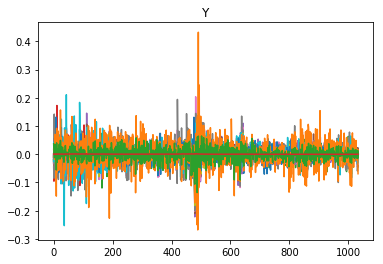

In [34]:
#data
import utils_ts
Koop=False
Mambrez=True
if Koop:
    path_csv=r'C:\Bolz\Dati\Koop_macro_TVP_VAR_plusDates.csv'
    financial_data=True
    monthly_data=False
    N=None
elif Mambrez:
    path_csv=r'C:\Bolz\Dati\Epsilon\MultiAsset ptf - returns.csv'
    financial_data=False
    monthly_data=False
    N=None
else:
    path_csv=r'C:\Bolz\Dati\DatiIndexesEquityDaFoglioFabrizio.csv'
    financial_data=True
    monthly_data=True
    N=10
p=6
if not path_csv is None and financial_data:#log returns for series
    y_df=pd.read_csv(path_csv,header=0,index_col=0)
    y_df=y_df.loc[(y_df>0).min(axis=1)]
    if not N is None:
        y=y_df.iloc[:,:N]
    else:
        y=y_df.iloc[:,:]
    if monthly_data:
        y=utils_ts.from_daily2_monthly(y,True)
        y=y.values
    else:
        y=np.log(y.values[1:,:]/y.values[:-1,:])    
    y,x=utils_ts.lagify(y,p)
    T,N=y.shape
elif not path_csv is None:#macro economics data
    y_df=pd.read_csv(path_csv,header=0,index_col=0)
    y=y_df.values
    y,x=utils_ts.lagify(y,p)
    T,N=y.shape
else:#synthetic data
    T=50
    N=25
    num_tril=int(N*(N+1)/2)
    y=np.random.randn(T,N)
    y=np.float32(y)
    y_df=pd.DataFrame(y)
    x=np.float32(x)
#some global numbers
num_tril=int(N*(N+1)/2)
num_regressors=x.shape[1]
num_var=N*num_regressors
plt.plot(y)
plt.title('Y')
plt.show()

START, SEED 2019
CV: 0
dcc covariance statistics:
min: -0.00043582780992399583
mean: 6.154018945506525e-05
max: 0.007290389105569566
std: 0.0002424319153317453
jumps filtering: overall mean is 0.012019230984151363
train round: -1
step time: 13.714080810546875


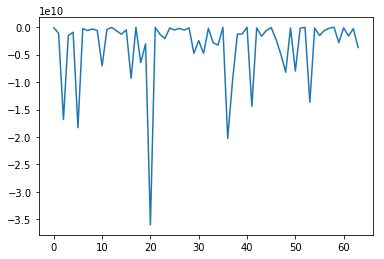

Entropies:
cholVcv -738604.1875, OU mu -1702.2265625, W -519158.25, OU rate -2.204376220703125


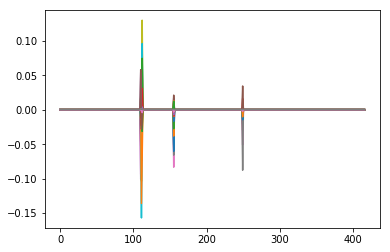

train round: 0
step time: 7.155360460281372
train round: 1
step time: 6.136601686477661


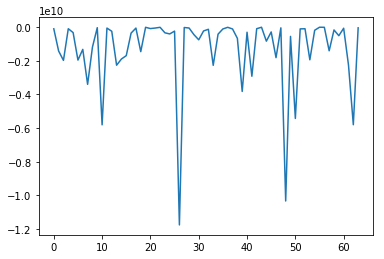

Entropies:
cholVcv -738601.1875, OU mu -1702.234375, W -519158.25, OU rate -2.2043838500976562


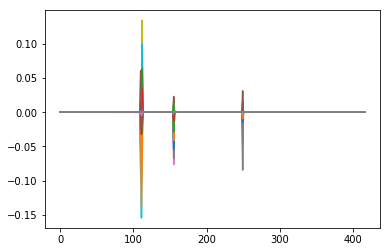

train round: 2
step time: 6.427286148071289
train round: 3
step time: 7.085291385650635


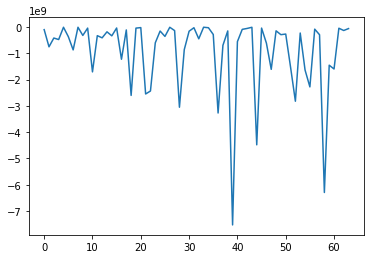

Entropies:
cholVcv -738599.0, OU mu -1702.25, W -519158.25, OU rate -2.2043991088867188


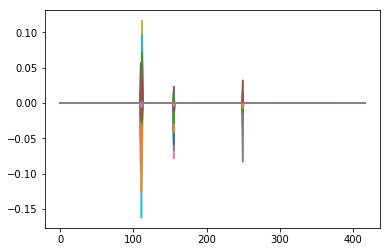

train round: 4
step time: 6.732508420944214


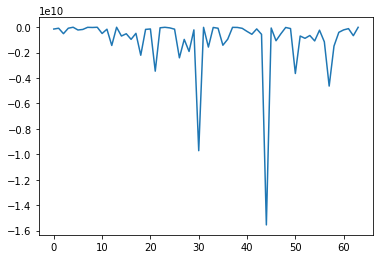

Entropies:
cholVcv -738598.1875, OU mu -1702.25, W -519158.25, OU rate -2.2043914794921875


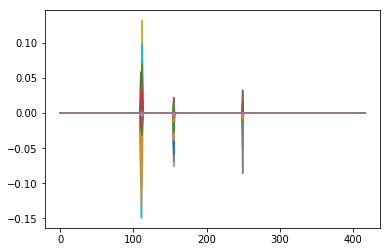

train round: 5
step time: 7.643574476242065


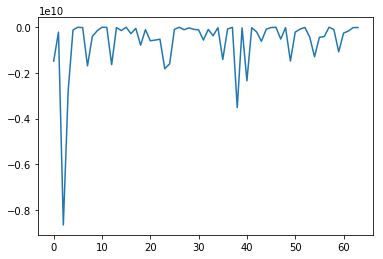

Entropies:
cholVcv -738597.375, OU mu -1702.25, W -519158.25, OU rate -2.20440673828125


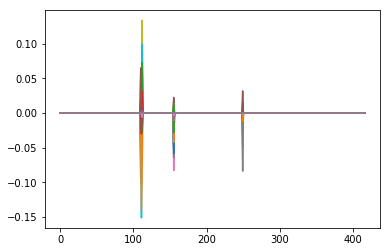

train round: 6
step time: 6.9823386669158936
train round: 7
step time: 6.561665058135986
train round: 8
step time: 6.539577007293701
train round: 9
step time: 6.15073299407959
train round: 10
step time: 6.183135032653809


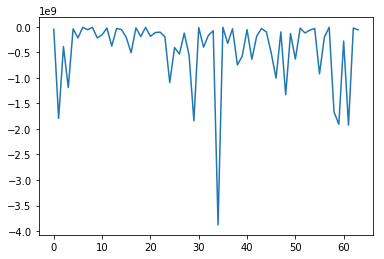

Entropies:
cholVcv -738592.3125, OU mu -1702.265625, W -519158.25, OU rate -2.2044219970703125


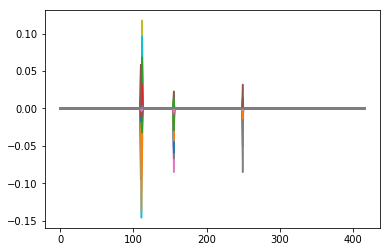

train round: 11
step time: 5.9786155223846436
train round: 12
step time: 5.997144937515259
train round: 13
step time: 6.227859735488892
train round: 14
step time: 6.196542024612427
train round: 15
step time: 6.13506555557251
train round: 16
step time: 6.110211610794067
train round: 17
step time: 6.148036003112793
train round: 18
step time: 6.2201855182647705
train round: 19
step time: 6.157536268234253
train round: 20
step time: 6.290695428848267
train round: 21
step time: 6.210402011871338
train round: 22
step time: 6.22119140625
train round: 23
step time: 6.354953289031982
train round: 24
step time: 6.317132949829102
train round: 25
step time: 6.418178558349609
train round: 26
step time: 6.2443015575408936
train round: 27
step time: 6.395655393600464
train round: 28
step time: 6.371479272842407
train round: 29
step time: 6.3346827030181885
train round: 30
step time: 6.436114549636841
train round: 31
step time: 6.39339280128479


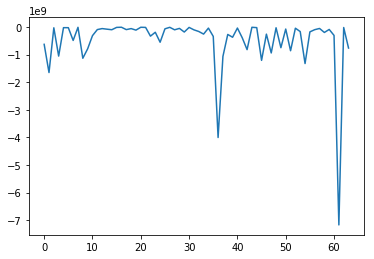

Entropies:
cholVcv -738570.5625, OU mu -1702.328125, W -519156.375, OU rate -2.2045135498046875


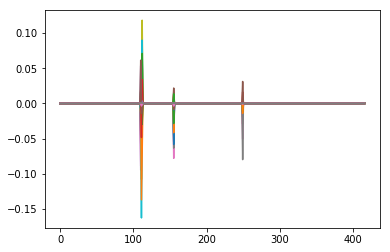

train round: 32
step time: 6.347784757614136
train round: 33
step time: 6.496876239776611


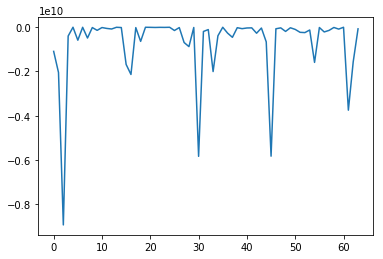

Entropies:
cholVcv -738568.4375, OU mu -1702.328125, W -519156.0, OU rate -2.2045135498046875


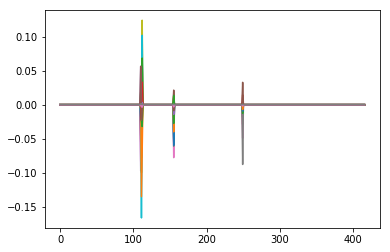

train round: 34
step time: 6.69498348236084
train round: 35
step time: 6.5449583530426025
train round: 36
step time: 6.501030206680298
train round: 37
step time: 6.486603736877441
train round: 38
step time: 6.527220249176025
train round: 39
step time: 6.69272780418396
train round: 40
step time: 6.615281105041504
train round: 41
step time: 6.623730421066284
train round: 42
step time: 6.665766000747681
train round: 43
step time: 7.55967378616333
train round: 44
step time: 7.036626815795898
train round: 45
step time: 7.633599758148193
train round: 46
step time: 7.101527214050293
train round: 47
step time: 7.592707633972168
train round: 48
step time: 6.967411041259766
train round: 49
step time: 7.74430251121521
train round: 50
step time: 8.318768739700317
train round: 51
step time: 8.38359522819519
train round: 52
step time: 7.784201622009277
train round: 53
step time: 7.283149719238281
train round: 54
step time: 7.49818754196167
train round: 55
step time: 7.181536674499512
train round: 56

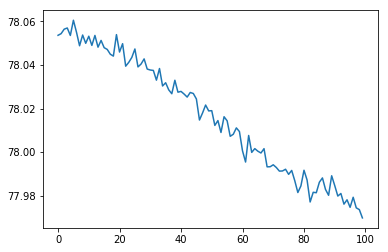

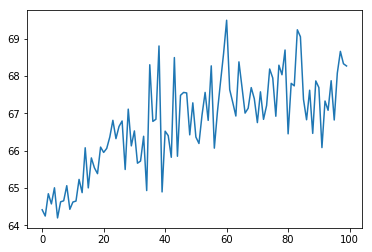

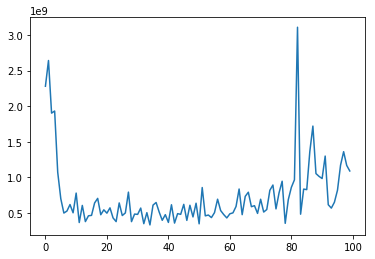

   cv  method                model      score        test      train
0   0  maxLkl                  DCC  log(P(y)) -430.845459   0.178126
1   0      VI  OUdiffJumps_wrapper  log(P(y))   69.398354  77.975609
2   0     MAP  OUdiffJumps_wrapper  log(P(y))   58.701492  78.001610
3   0  maxLkl  OUdiffJumps_wrapper  log(P(y))   63.335014  78.082289
CV: 1
dcc covariance statistics:
min: -0.0011682471850318096
mean: 8.705924213480458e-05
max: 0.03250739273382385
std: 0.0003642215627737367
jumps filtering: overall mean is 0.03501400724053383
train round: -1
step time: 14.785449981689453


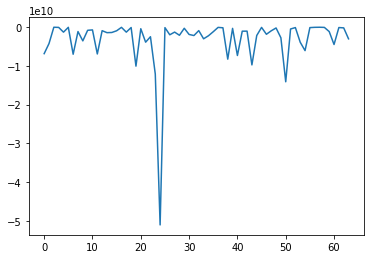

Entropies:
cholVcv -1353733.5, OU mu -1671.90625, W -504892.34375, OU rate -2.22662353515625


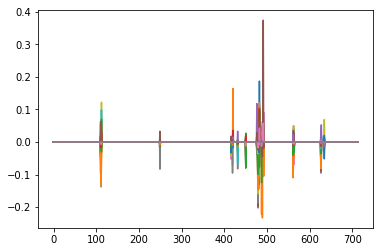

train round: 0
step time: 8.612698078155518


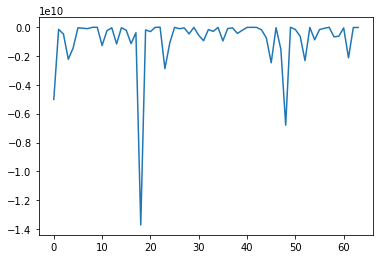

Entropies:
cholVcv -1353733.0, OU mu -1671.90625, W -504892.34375, OU rate -2.2266311645507812


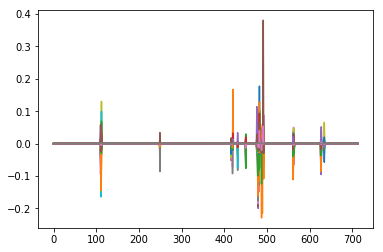

train round: 1
step time: 10.527862787246704


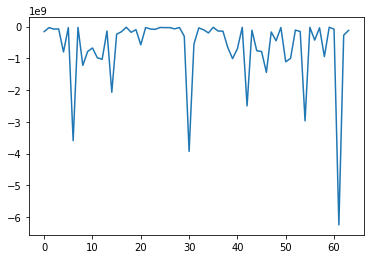

Entropies:
cholVcv -1353732.5, OU mu -1671.9140625, W -504892.34375, OU rate -2.22662353515625


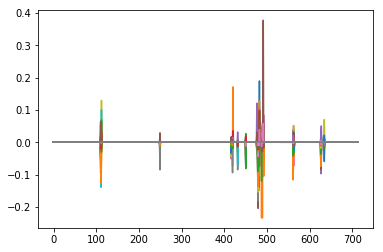

train round: 2
step time: 10.28165578842163
train round: 3
step time: 9.315138816833496
train round: 4
step time: 9.477445602416992


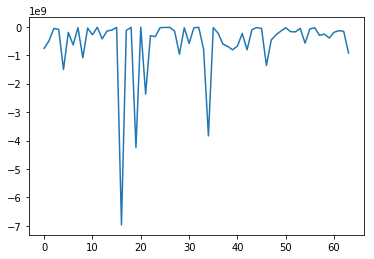

Entropies:
cholVcv -1353729.375, OU mu -1671.921875, W -504892.34375, OU rate -2.22662353515625


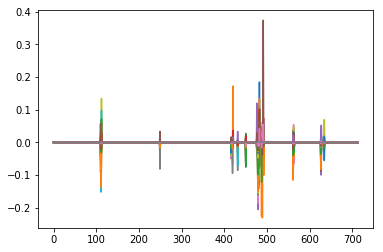

train round: 5
step time: 9.562811374664307


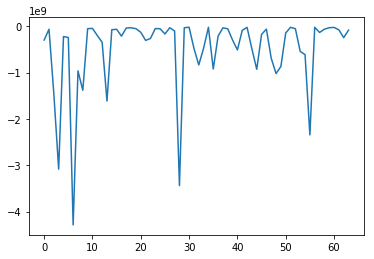

Entropies:
cholVcv -1353727.375, OU mu -1671.921875, W -504892.34375, OU rate -2.2266387939453125


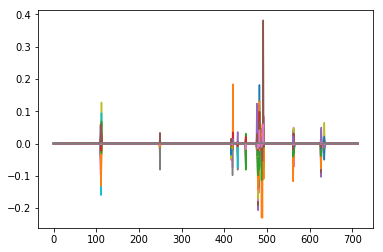

train round: 6
step time: 8.906201601028442
train round: 7
step time: 9.759922742843628
train round: 8
step time: 10.10051703453064
train round: 9
step time: 12.476655721664429


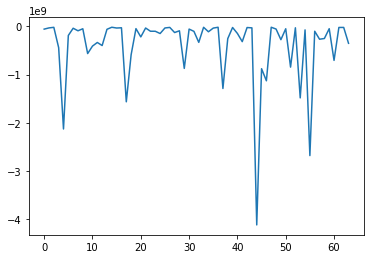

Entropies:
cholVcv -1353719.5, OU mu -1671.921875, W -504892.34375, OU rate -2.226654052734375


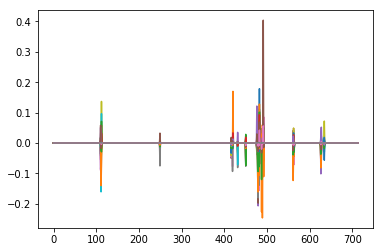

train round: 10
step time: 9.171869039535522
train round: 11
step time: 9.483177423477173
train round: 12
step time: 9.705611228942871
train round: 13
step time: 12.58363151550293
train round: 14
step time: 11.985825777053833
train round: 15
step time: 10.761139154434204
train round: 16
step time: 10.630242347717285


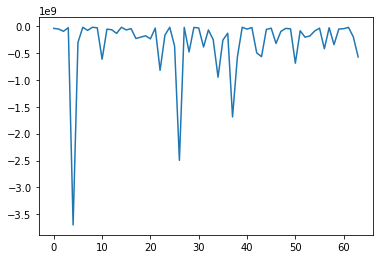

Entropies:
cholVcv -1353711.5, OU mu -1671.9375, W -504892.28125, OU rate -2.2266616821289062


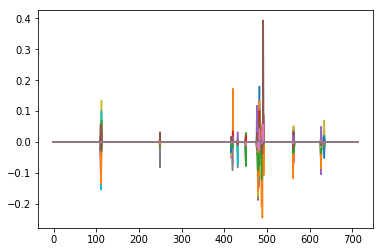

train round: 17
step time: 12.46549940109253
train round: 18
step time: 12.674129486083984
train round: 19
step time: 10.570051431655884
train round: 20
step time: 13.33735990524292
train round: 21
step time: 12.179141998291016
train round: 22
step time: 11.531046390533447
train round: 23
step time: 17.097343683242798
train round: 24
step time: 16.164825916290283
train round: 25
step time: 15.212307691574097
train round: 26
step time: 14.769506454467773
train round: 27
step time: 16.871607065200806
train round: 28
step time: 15.400807619094849
train round: 29
step time: 15.055731058120728
train round: 30
step time: 17.655160665512085
train round: 31
step time: 15.810746908187866
train round: 32


In [ ]:
_seed=2019
dt=1
CV=20
MC=64
logPy_scoreName='log(P(y))'
np.random.seed(_seed)
print(f'START, SEED {_seed}')
#object to log the results
log_results=[]
graph_results={}
split_times_ios=np.random.choice(np.arange(int(T/3),T-dt),CV)
train_epochs_forced=100
for cv in range(CV):
    #try:
        print(f'CV: {cv}')
        tf.set_random_seed(_seed)
        t1=split_times_ios[cv]
        y_train=y[:t1]
        y_test=y[t1:t1+dt]
        def model_run(VIwrapper):
            #audit_=audit('AMaMeF'+VIwrapper.name,r'C:\Bolz\PhD\TVP_VAR_SV\results',None)
            audit_=None
            init = tf.global_variables_initializer()        
            with tf.Session() as sess:
                sess.run(init)
                elbo,llkl_test,llkl_train=VIwrapper.run_inference(sess,y_forecast=y_test,audit=audit_,diagnostic=True)
                perf_test,perf_train=VIwrapper.get_logPy(y_test,sess,size_MC=MC*20)
                log_and_plot(VIwrapper,elbo,llkl_train,llkl_test,perf_test,perf_train,t1,cv,log_results=log_results)
            if not VIwrapper.name in graph_results:
                graph_results[VIwrapper.name]=np.zeros([CV,VIwrapper.estimatorVI.optim_KL.train_epochs_limit_max,3])
            graph_results[VIwrapper.name][cv][:,0]=elbo
            graph_results[VIwrapper.name][cv][:,2]=llkl_train
            graph_results[VIwrapper.name][cv][:,1]=llkl_test

            print(pd.DataFrame(log_results))
            return audit_
        tf.reset_default_graph()    
        DCC_test,DCC_train=DCC_fit_and_evaluate(y_train,y_test,sess=None)
        perf={'method':'maxLkl','model':'DCC','score':'log(P(y))','test':DCC_test[0],'train':DCC_train.mean(),'cv':cv}
        log_results.append(perf)
        #DCC=VIwrapper_DCC('DCC',y_train,MC,1/N**2,train_epochs_limit_min=10,train_epochs_limit_max=10)
        #model_run(DCC)
        tf.reset_default_graph()
        OUdiffJumps=VIwrapper_JumpsOUdiff('OUdiffJumps',y_train,MC,jumps=True,train_epochs_limit_min=train_epochs_forced,train_epochs_limit_max=train_epochs_forced)
        audit_oudiffjumps=model_run(OUdiffJumps)
        tf.reset_default_graph()
        #OUdiff=VIwrapper_JumpsOUdiff('OUdiff',y_train,MC,jumps=False,train_epochs_limit_min=train_epochs_forced,train_epochs_limit_max=train_epochs_forced)
        #audit_oudiff=model_run(OUdiff)
    #except:
    #    print('err')

In [ ]:
#the audit used to save the results
audit_=audit('AMaMeF_log_results',r'C:\Bolz\PhD\TVP_VAR_SV\results',None)
path2save=audit_.folder2save+r'\results_scatter.png'
_df=pd.DataFrame(log_results)
_df.to_csv(audit_.folder2save+r'\results.csv')
_df=_df[_df['cv']>0]
#plots the CV-results
_mark=0
markers=['*','^','o']
for men,med in _df.groupby('method'):
    for mon,momed in med.groupby('model'):
        #if not ((mon)=='OUdiff' or mon=='OUdiffJumps'):
        #if not ( (mon=='DCC')):
            plt.scatter(momed['train'].mean(),momed['test'].mean(),label=mon+' '+men,marker=markers[_mark],s=40.0)
            plt.errorbar(momed['train'].mean(),momed['test'].mean(),xerr=momed['train'].std(),yerr=momed['test'].std(),marker=markers[_mark])
    _mark+=1
lgd=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(path2save,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
#trace-plot
for mod in graph_results:
    _g=graph_results[mod]
    print(f'{mod} {_g.mean(axis=0).shape}')
    path2save=audit_.folder2save+f'\\results_tracePlot_{mod}.png'
    fig, ax =plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False)
    for _ in range(3):
        ax[_].plot(_g.mean(axis=0)[:,_])        
    fig.suptitle(f'Trace plot of {mod}')
    fig.savefig(path2save, bbox_inches='tight')
    plt.show()


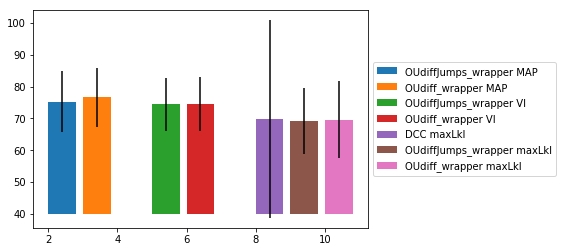

OUdiffJumps_wrapper (100, 3)


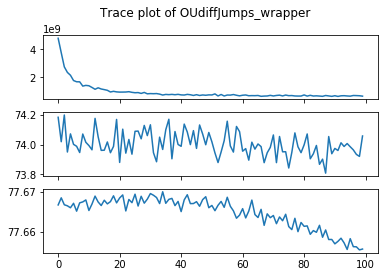

OUdiff_wrapper (100, 3)


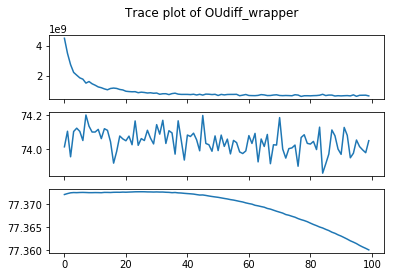

In [50]:
#the audit used to save the results
audit_=audit('AMaMeF_log_results',r'C:\Bolz\PhD\TVP_VAR_SV\results',None)
path2save=audit_.folder2save+r'\results_scatter.png'
_df=pd.DataFrame(log_results)
_df.to_csv(audit_.folder2save+r'\results.csv')
_df=_df[_df['cv']>0]
#plots the CV-results
_mark=0
markers=['*','^','o']
x=0
w=0
width=1
bottom=40
for men,med in _df.groupby('method'):
    x+=width
    #w=width
    #x=0
    for mon,momed in med.groupby('model'):      
        x+=width
        #w+=width
        #if not ((mon)=='OUdiff' or mon=='OUdiffJumps'):
        #if not ( (mon=='DCC')):        
        plt.bar(x, momed['test'].mean()-bottom, align='edge',yerr=momed['test'].std(),label=mon+' '+men,bottom=bottom)
            #plt.bar()
            #plt.scatter(momed['train'].mean(),momed['test'].mean(),label=mon+' '+men,marker=markers[_mark],s=40.0)
            #plt.errorbar(momed['train'].mean(),momed['test'].mean(),xerr=momed['train'].std(),yerr=momed['test'].std(),marker=markers[_mark])
    _mark+=1
lgd=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig(path2save,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
#trace-plot
for mod in graph_results:
    _g=graph_results[mod]
    print(f'{mod} {_g.mean(axis=0).shape}')
    path2save=audit_.folder2save+f'\\results_tracePlot_{mod}.png'
    fig, ax =plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False)
    for _ in range(3):
        ax[_].plot(_g.mean(axis=0)[:,_])        
    fig.suptitle(f'Trace plot of {mod}')
    #fig.savefig(path2save, bbox_inches='tight')
    plt.show()


In [ ]:
###SPAM

a (500, 3)


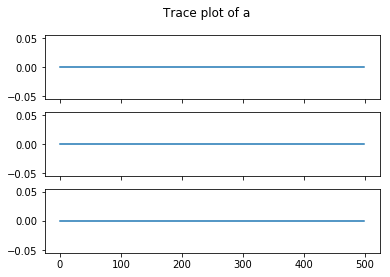

b (500, 3)


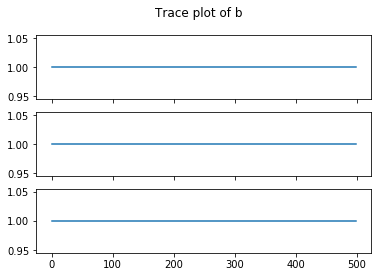

In [35]:
graph_results={'a':np.zeros([CV,train_epochs_forced,3]),'b':np.ones([CV,train_epochs_forced,3])}
for mod in graph_results:
    _g=graph_results[mod]
    print(f'{mod} {_g.mean(axis=0).shape}')
    path2save=audit_.folder2save+f'\\results_tracePlot {mod}.png'
    fig, ax =plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False)
    for _ in range(3):
        ax[_].plot(_g.mean(axis=0)[:,_])        
    fig.suptitle(f'Trace plot of {mod}')
    fig.savefig(path2save, bbox_inches='tight')
    plt.show()

In [311]:
elbo

array([-3426.48950195])

In [314]:
graph_results[DCC.name][cv][0,:-1]=elbo
graph_results[DCC.name][cv][0,:-1]=llkl_test
graph_results[DCC.name][cv][0,:-1]=llkl_train

In [317]:
graph_results[DCC.name][cv][0]

array([   27.30317879,    27.31619263, -3426.48950195])

In [39]:
pd.DataFrame(log_results)

,cv,method,model,score,test,train
0,0,VI,DCC,log(P(y)),21.480782,21.706306
1,0,MAP,DCC,log(P(y)),22.043962,21.663875
2,0,maxLkl,DCC,log(P(y)),20.770294,21.668223
3,0,VI,OUdiffJumps_wrapper,log(P(y)),17.684399,17.606939
4,0,MAP,OUdiffJumps_wrapper,log(P(y)),11.704424,20.832904
5,0,maxLkl,OUdiffJumps_wrapper,log(P(y)),10.012470,21.963516


In [1]:
graph_results

NameError: name 'graph_results' is not defined

In [15]:
graph_results[DCC.name][cv][:,0]

array([0., 0., 0., 0., 0.])

In [16]:
elbo

array([-3452.13720703, -3457.46484375, -3458.95727539, -3429.6965332 ])

START, SEED 2019
CV: 0
min: 0.0004412915165541161
mean: 0.0020645706606094412
max: 0.018073337297974758
std: 0.0015978802621951118
dcc stats:
None
train round: -1
evolved Vcv (64, 1, 5, 5)
evolved Ey (64, 1, 5)
model insight:
(1, 5)
(64, 1, 5, 5)

[[[[0.03316063 0.         0.         0.         0.        ]
   [0.03993281 0.02762814 0.         0.         0.        ]
   [0.04409178 0.01213464 0.05387425 0.         0.        ]
   [0.02847999 0.00907571 0.00038409 0.01370431 0.        ]
   [0.04176617 0.01787404 0.00207292 0.00715228 0.03145728]]]


 [[[0.04337077 0.         0.         0.         0.        ]
   [0.03347549 0.02340544 0.         0.         0.        ]
   [0.04199874 0.0126746  0.0531427  0.         0.        ]
   [0.03005691 0.0092467  0.00037932 0.01470005 0.        ]
   [0.02530771 0.01050283 0.00206366 0.00525524 0.01950692]]]


 [[[0.0338284  0.         0.         0.         0.        ]
   [0.03425119 0.02563476 0.         0.         0.        ]
   [0.02827102 0.0196853

MCo: 640
evolved Vcv (1, 1, 5, 5)
evolved Ey (1, 1, 5)
model insight:
(1, 5)
(1, 1, 5, 5)

[[[[0.04017807 0.         0.         0.         0.        ]
   [0.04703732 0.03250227 0.         0.         0.        ]
   [0.0436861  0.01207347 0.05367868 0.         0.        ]
   [0.03248533 0.01030363 0.00044059 0.01566361 0.        ]
   [0.0275399  0.01170055 0.00153291 0.00485076 0.02081129]]]]
MCo: 1
evolved Vcv (1, 1, 5, 5)
evolved Ey (1, 1, 5)
model insight:
(1, 5)
(1, 1, 5, 5)

[[[[0.04017807 0.         0.         0.         0.        ]
   [0.04703732 0.03250227 0.         0.         0.        ]
   [0.0436861  0.01207347 0.05367868 0.         0.        ]
   [0.03248533 0.01030363 0.00044059 0.01566361 0.        ]
   [0.0275399  0.01170055 0.00153291 0.00485076 0.02081129]]]]
MCo: 1
DCC


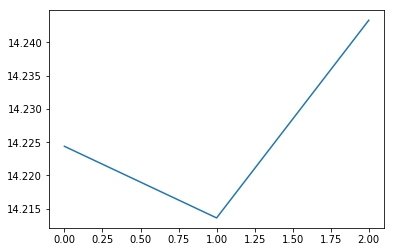

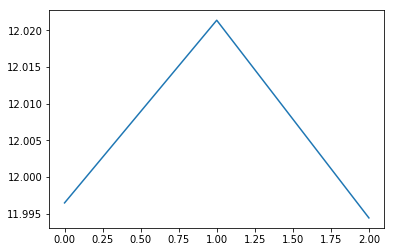

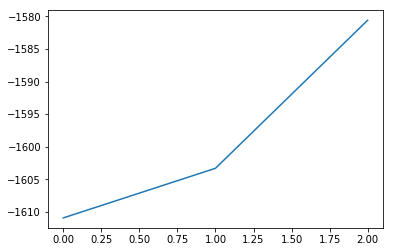

jumps filtering: correction for mean applied
jumps filtering: overall mean is 0.005988024175167084
Ey: Tensor("mul_9:0", shape=(64, 167, 5), dtype=float32)
jumpsSoftId: <__main__.VIsampler_tvpBernoulli_soft object at 0x000002630BCF5550>
Tensor("mul_9:0", shape=(64, 167, 5), dtype=float32)
Tensor("transform_diagonal/forward/MatrixSetDiag:0", shape=(64, 167, 5, 5), dtype=float32)
train round: -1
evolved cholVcv (64, 1, 5, 5)
evolved Ey (64, 1, 5)
MCo: 64
step time: 2.3526830673217773
train round: 0
evolved cholVcv (64, 1, 5, 5)
evolved Ey (64, 1, 5)
MCo: 64
step time: 0.7769227027893066
train round: 1
evolved cholVcv (64, 1, 5, 5)
evolved Ey (64, 1, 5)
MCo: 64
step time: 0.7659528255462646
wella: (640, 167, 5, 5)
wella: (640, 167, 15)
wella: (640, 15, 15)
wella: (640,)
wella: (640, 5, 5)
wella: (640, 15)
wella: (640, 167, 5)
wella: (640, 1)
wella: (640, 5)
wella: (640, 5, 5)
wella: (640, 167, 5)
wella: (640, 167, 5)


KeyError: 'Vcv'

In [169]:
_seed=2019
dt=1
CV=1
MC=64
logPy_scoreName='log(P(y))'
np.random.seed(_seed)
print(f'START, SEED {_seed}')
#object to log the results
log_results=[]
graph_results={}
split_times_ios=np.random.choice(np.arange(int(T/2),T-dt),CV)
train_epochs_forced=3
for cv in range(CV):
    def model_run(VIwrapper):
        init = tf.global_variables_initializer()        
        with tf.Session() as sess:
            sess.run(init)
            elbo,llkl_test,llkl_train=VIwrapper.run_inference(sess,y_forecast=y_test)
            perf_test,perf_train=VIwrapper.get_logPy(y_test,sess,size_MC=MC*10)
            log_and_plot(VIwrapper,elbo,llkl_train,llkl_test,perf_test,perf_train,t1,cv,log_results=log_results)
        if not DCC.name in graph_results:
            graph_results[VIwrapper.name]=np.zeros([CV,train_epochs_forced,3])
        graph_results[DCC.name][cv][:,0]=elbo
        graph_results[DCC.name][cv][:,1]=llkl_test
        graph_results[DCC.name][cv][:,2]=llkl_train
    #try:
        print(f'CV: {cv}')        
        tf.set_random_seed(_seed)
        t1=split_times_ios[cv]
        y_train=y[:t1]
        y_test=y[t1:t1+dt]
        #DCC
        tf.reset_default_graph()
        DCC=VIwrapper_DCC('DCC',y_train,MC,1/t1,train_epochs_limit_min=train_epochs_forced,train_epochs_limit_max=train_epochs_forced)
        init = tf.global_variables_initializer()        
        with tf.Session() as sess:
            sess.run(init)
            elbo,llkl_test,llkl_train=DCC.run_inference(sess,y_forecast=y_test)
            print(elbo,llkl_test,llkl_train)
            perf_test,perf_train=DCC.get_logPy(y_test,sess,size_MC=MC*10)
            log_and_plot(DCC,elbo,llkl_train,llkl_test,perf_test,perf_train,t1,cv,log_results=log_results)
        if not DCC.name in graph_results:
            graph_results[DCC.name]=np.zeros([CV,train_epochs_forced,3])
        graph_results[DCC.name][cv][:,0]=elbo
        graph_results[DCC.name][cv][:,2]=llkl_train
        graph_results[DCC.name][cv][:,1]=llkl_test
        
        #diffusion matrix+jumps
        tf.reset_default_graph()
        OUdiffJumps=VIwrapper_JumpsOUdiff('OUdiffJumps',y_train,MC,jumps=True,init_vcv=DCC.dcc_vcv_train,train_epochs_limit_min=train_epochs_forced,train_epochs_limit_max=train_epochs_forced)
        init = tf.global_variables_initializer()  
        with tf.Session() as sess:
            sess.run(init)
            elbo,llkl_test,llkl_train=OUdiffJumps.run_inference(sess,y_forecast=y_test)
            perf_test,perf_train=OUdiffJumps.get_logPy(y_test,sess,size_MC=MC*10)
            log_and_plot(OUdiffJumps,elbo,llkl_train,llkl_test,perf_test,perf_train,t1,cv,log_results=log_results)
        if not OUdiffJumps.name in graph_results:
            graph_results[OUdiffJumps.name]=np.zeros([CV,train_epochs_forced,3])
        graph_results[OUdiffJumps.name][cv][:,0]=elbo
        graph_results[OUdiffJumps.name][cv][:,1]=llkl_test
        graph_results[OUdiffJumps.name][cv][:,2]=llkl_train
        #diffusion matrix+jumps, rolling init
        tf.reset_default_graph()
        OUdiffJumps=VIwrapper_JumpsOUdiff('OUdiffJumps_roll',y_train,MC,jumps=True,train_epochs_limit_min=train_epochs_forced,train_epochs_limit_max=train_epochs_forced)
        init = tf.global_variables_initializer()  
        with tf.Session() as sess:
            sess.run(init)
            elbo,llkl_test,llkl_train=OUdiffJumps.run_inference(sess,y_forecast=y_test)
            perf_test,perf_train=OUdiffJumps.get_logPy(y_test,sess)
            log_and_plot(OUdiffJumps,elbo,llkl_train,llkl_test,perf_test,perf_train,t1,cv,log_results=log_results)  
        if not OUdiffJumps.name in graph_results:
            graph_results[OUdiffJumps.name]=np.zeros([CV,train_epochs_forced,3])
        graph_results[OUdiffJumps.name][cv][:,0]=elbo
        graph_results[OUdiffJumps.name][cv][:,1]=llkl_test
        graph_results[OUdiffJumps.name][cv][:,2]=llkl_train
        #diffusion matrix
        tf.reset_default_graph()
        OUdiff=VIwrapper_JumpsOUdiff('OUdiff',y_train,MC,jumps=False,init_vcv=DCC.dcc_vcv_train,train_epochs_limit_min=train_epochs_forced,train_epochs_limit_max=train_epochs_forced)
        init = tf.global_variables_initializer()  
        with tf.Session() as sess:
            sess.run(init)
            elbo,llkl_test,llkl_train=OUdiff.run_inference(sess,y_forecast=y_test)
            perf_test,perf_train=OUdiff.get_logPy(y_test,sess,size_MC=MC*10)
            log_and_plot(OUdiff,elbo,llkl_train,llkl_test,perf_test,perf_train,t1,cv,log_results=log_results)
        if not OUdiff.name in graph_results:
            graph_results[OUdiff.name]=np.zeros([CV,train_epochs_forced,3])
        graph_results[OUdiff.name][cv][:,0]=elbo
        graph_results[OUdiff.name][cv][:,1]=llkl_test
        graph_results[OUdiff.name][cv][:,2]=llkl_train
        #diffusion matrix,rolling
        tf.reset_default_graph()
        OUdiff=VIwrapper_JumpsOUdiff('OUdiff_roll',y_train,MC,jumps=False,train_epochs_limit_min=train_epochs_forced,train_epochs_limit_max=train_epochs_forced)
        init = tf.global_variables_initializer()  
        with tf.Session() as sess:
            sess.run(init)
            elbo,llkl_test,llkl_train=OUdiff.run_inference(sess,y_forecast=y_test)
            perf_test,perf_train=OUdiff.get_logPy(y_test,sess)
            log_and_plot(OUdiff,elbo,llkl_train,llkl_test,perf_test,perf_train,t1,cv,log_results=log_results)
        if not OUdiff.name in graph_results:
            graph_results[OUdiff.name]=np.zeros([CV,train_epochs_forced,3])
        graph_results[OUdiff.name][cv][:,0]=elbo
        graph_results[OUdiff.name][cv][:,1]=llkl_test
        graph_results[OUdiff.name][cv][:,2]=llkl_train
    #except:
    #    print('err')
        

In [18]:
llkl_train

[27.30809, 27.318684, 27.328423, 27.298336, 27.316227]

In [22]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    elbo,llkl_test,llkl_train=OUdiffJumps.run_inference(sess,y_forecast=y_test)
    perf_test,perf_train=OUdiffJumps.get_logPy(y_test,sess,size_MC=MC*10)

array([-3452.13720703, -3457.46484375, -3458.95727539, -3429.6965332 ,
       -3465.72216797])

In [54]:
graph_results

{'DCC': array([[[-3427.42089844,    21.46215248,    27.31425476],
         [-3470.90063477,    21.56964302,    27.33561897],
         [-3446.53955078,    21.57852554,    27.32137108],
         ...,
         [-3435.17456055,    21.45091248,    27.30965233],
         [-3458.32763672,    21.27424049,    27.29473686],
         [-3471.42138672,    21.46837807,    27.33384323]],
 
        [[-2637.21386719,    23.30409622,    27.55991364],
         [-2638.74707031,    23.4372406 ,    27.52902222],
         [-2645.90014648,    23.51457596,    27.54556274],
         ...,
         [-2633.36108398,    23.51712799,    27.51169014],
         [-2642.42333984,    23.48352814,    27.54492188],
         [-2641.6418457 ,    23.5207901 ,    27.53781128]],
 
        [[-2740.16625977,    20.20226479,    27.48764992],
         [-2733.21655273,    20.21845245,    27.46354866],
         [-2725.51025391,    20.36841393,    27.4751358 ],
         ...,
         [-2735.86181641,    20.17902374,    27.45003891],
 

In [53]:
momed

,cv,method,model,score,test,train
1,0,MAP,DCC,log(P(y)),21.616524,21.672118
16,1,MAP,DCC,log(P(y)),23.233028,22.006330
31,2,MAP,DCC,log(P(y)),20.362770,21.946389
46,3,MAP,DCC,log(P(y)),21.373505,21.836258
61,4,MAP,DCC,log(P(y)),24.141539,21.675293
76,5,MAP,DCC,log(P(y)),20.355484,22.046992
91,6,MAP,DCC,log(P(y)),22.023380,21.986521
106,7,MAP,DCC,log(P(y)),15.558558,22.532191
121,8,MAP,DCC,log(P(y)),8.253553,22.649727
136,9,MAP,DCC,log(P(y)),-4.275227,22.499184


DCC (3, 3)


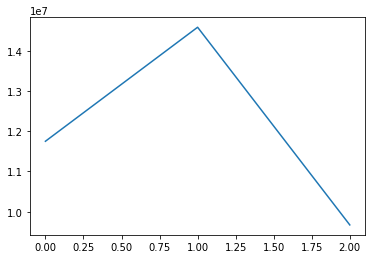

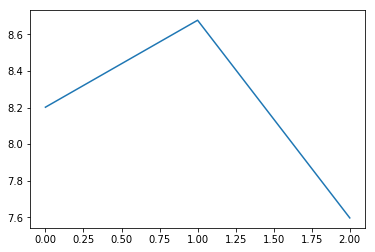

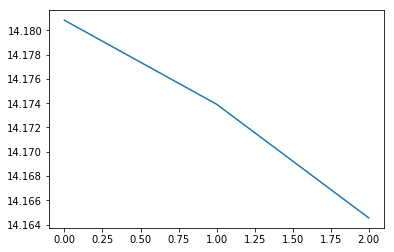

In [15]:
log_results

[{'cv': 0,
  'method': 'VI',
  'model': 'DCC',
  'score': 'log(P(y))',
  'test': 12.017666,
  'train': 10.057335036957335},
 {'cv': 0,
  'method': 'MAP',
  'model': 'DCC',
  'score': 'log(P(y))',
  'test': 12.029354,
  'train': 9.9402213639128},
 {'cv': 0,
  'method': 'maxLkl',
  'model': 'DCC',
  'score': 'log(P(y))',
  'test': 12.029354,
  'train': 9.9402213639128},
 {'cv': 0,
  'method': 'VI',
  'model': 'OUdiffJumps_wrapper',
  'score': 'log(P(y))',
  'test': 8.261139,
  'train': 9.995349632765718},
 {'cv': 0,
  'method': 'MAP',
  'model': 'OUdiffJumps_wrapper',
  'score': 'log(P(y))',
  'test': -3245.8257,
  'train': 10.005651782372755},
 {'cv': 0,
  'method': 'maxLkl',
  'model': 'OUdiffJumps_wrapper',
  'score': 'log(P(y))',
  'test': -10.559982,
  'train': 10.022425851422156}]

In [17]:
graph_results.keys()

dict_keys(['DCC'])

In [50]:
OUdiffJumps.estimatorVI.optim_KL.is_min_value[458:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [141]:
init = tf.global_variables_initializer()        
with tf.Session() as sess:
    sess.run(init)
    audit_oudiff.restore_tensorflow(sess)
    qui=sess.run(OUdiff.estimatorVI.p0)
    qui=sess.run(OUdiff.sampler.states['cholVcv'])    
    qua=np.min(qui[:,:,np.diag_indices(N)[0],np.diag_indices(N)[1]])
    print(qua)
    #print((OUdiff.get_logPy(y_test,sess)))

INFO:tensorflow:Restoring parameters from C:\Bolz\PhD\TVP_VAR_SV\results\AMaMeFOUdiff_wrapper 20190606 214714\tf
0.0021301454


In [123]:
pd.DataFrame(log_results)

,cv,method,model,score,test,train
0,0,maxLkl,DCC,log(P(y)),"[96.0928, 99.65271, 98.05489, 96.66991, 99.034...",40.534870
1,0,VI,OUdiffJumps_wrapper,log(P(y)),80.6934,77.715190
2,0,MAP,OUdiffJumps_wrapper,log(P(y)),83.6683,77.464158
3,0,maxLkl,OUdiffJumps_wrapper,log(P(y)),78.6366,77.563872


{'OUdiffJumps_wrapper': array([[[3.76934656e+08, 8.50270844e+00, 1.59145470e+01],
         [5.32099936e+08, 7.03585434e+00, 1.59248524e+01],
         [3.42070400e+09, 7.81516457e+00, 1.59122543e+01],
         [1.00536870e+09, 8.46870422e+00, 1.58947496e+01],
         [1.89571776e+09, 8.19180012e+00, 1.58646059e+01],
         [1.07364032e+09, 7.36783409e+00, 1.58196983e+01],
         [5.28384576e+08, 8.61984062e+00, 1.57586870e+01],
         [2.86421344e+08, 8.16983795e+00, 1.56825724e+01],
         [3.88289856e+08, 8.86567116e+00, 1.55953054e+01],
         [4.32412448e+08, 8.23599720e+00, 1.54969988e+01],
         [3.24503296e+08, 7.49138069e+00, 1.53906946e+01],
         [4.58132992e+08, 7.28952885e+00, 1.52792387e+01],
         [8.05009600e+08, 7.88059807e+00, 1.51712122e+01],
         [1.84716032e+09, 7.57361031e+00, 1.50739784e+01],
         [1.66429542e+09, 8.52126503e+00, 1.49893436e+01],
         [7.05255616e+08, 8.16156864e+00, 1.49175625e+01],
         [5.93798272e+08, 8.98339

In [28]:
_seed=2019
dt=1
CV=10
MC=64
logPy_scoreName='log(P(y))'
np.random.seed(_seed)
print(f'START, SEED {_seed}')
#object to log the results
log_results=[]
graph_results={}
split_times_ios=np.random.choice(np.arange(int(T/3),T-dt),CV)
split_times_ios

START, SEED 2019


array([416, 714, 503, 534, 368, 615, 740, 450, 360, 520])

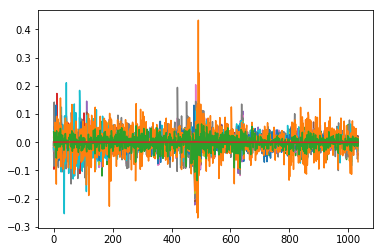

In [30]:
plt.plot(y)
plt.show()

In [22]:
pd.DataFrame(log_results).iloc[30:100]

,cv,method,model,score,test,train
30,4,MAP,OUdiffJumps_wrapper,log(P(y)),58.607388,76.894091
31,4,maxLkl,OUdiffJumps_wrapper,log(P(y)),62.350632,76.982241
32,4,VI,OUdiff_wrapper,log(P(y)),81.694580,76.775104
33,4,MAP,OUdiff_wrapper,log(P(y)),85.275612,76.811141
34,4,maxLkl,OUdiff_wrapper,log(P(y)),77.939781,76.822563
35,5,maxLkl,DCC,log(P(y)),76.820038,35.732208
36,5,VI,OUdiffJumps_wrapper,log(P(y)),81.991859,77.003189
37,5,MAP,OUdiffJumps_wrapper,log(P(y)),83.958488,76.802312
38,5,maxLkl,OUdiffJumps_wrapper,log(P(y)),77.916641,76.954865
39,5,VI,OUdiff_wrapper,log(P(y)),81.938568,76.648450


In [78]:
np.log(300)

5.703782474656201

In [81]:
(65+93+75)/3

77.66666666666667

In [88]:
_seed=2019
dt=1
CV=20
MC=64
logPy_scoreName='log(P(y))'
np.random.seed(_seed)
print(f'START, SEED {_seed}')
#object to log the results
log_results=[]
graph_results={}
split_times_ios=np.random.choice(np.arange(int(T/3),T-dt),CV)
split_times_ios

START, SEED 2019


array([416, 714, 503, 534, 368, 615, 740, 450, 360, 520, 543, 939, 356,
       477, 719, 628, 972, 776, 819, 999])